**ВНИМАНИЕ!** Данный ноутбук должен запускаться в Google Colab, либо поменяйте все ячейки с получением данных из Google Drive на локальное подтягивание.

## Результат baseline'а

Напоминаем метрики бейзлайна (стемминг + tf-tdf + логистическая регрессия с подбором гиперпараметров)
- Негативные — Precision=0.79, Recall=0.70, F1=0.74
- Позитивные — Precision=0.95, Recall=0.97, F1=0.96
- Accuracy — 0.93

Обучали на датасете WB, подтянем его же для эксперементов

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import torch
import time
from transformers import AutoTokenizer, AutoModel

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/classification_of_reviews/wb_reviews.csv"

data = pd.read_csv(file_path)

Mounted at /content/drive


## Предобработка текста

In [ ]:
data['Rating'] = data['Rating'].apply(lambda x: x*2)
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)
data = data.dropna()

In [ ]:
data_clean = data.copy()
data_clean['Russian chars'] = data_clean['Review'].apply(lambda s: len(re.findall(r'[а-яА-Я]', s)))
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## DecisionTreeClassifier

In [ ]:
dt_pipeline = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [ ]:
pred = dt_pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      6675
           1       0.94      0.94      0.94     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.77      0.77     47419
weighted avg       0.89      0.89      0.89     47419



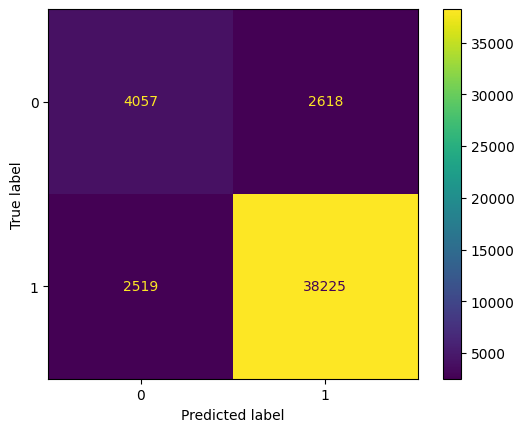

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(dt_pipeline, X_test['Review'], y_test)

## RandomForestClassifier

In [ ]:
rf_pipeline = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1))
])

rf_pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [ ]:
pred = rf_pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      6675
           1       0.92      0.98      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.87      0.72      0.77     47419
weighted avg       0.91      0.91      0.90     47419



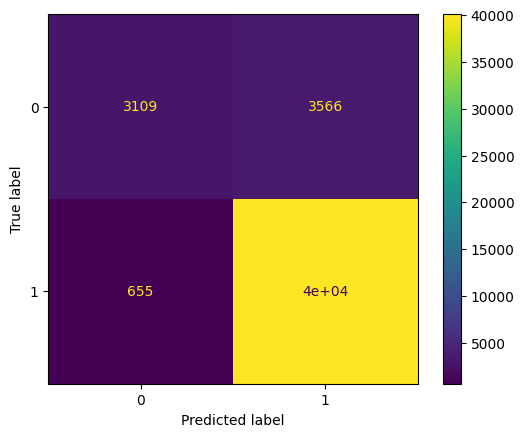

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test['Review'], y_test)

## DecisionTreeClassifier с весами классов

In [ ]:
dt_pipeline_weights = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'clf__class_weight': ['balanced', {0: 2, 1: 1}, {0: 3, 1: 1}]
}

grid_search_weights = GridSearchCV(dt_pipeline_weights, param_grid, cv=2,
                                   scoring='recall', n_jobs=-1)
grid_search_weights.fit(X_train['Review'], y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': ['balanced', {0: 2, 1: 1},
                                               {0: 3, 1: 1}]},
             scoring='recall')

In [ ]:
print("Weights params:", grid_search_weights.best_params_)
print("Best recall:", grid_search_weights.best_score_)

Weights params: {'clf__class_weight': {0: 2, 1: 1}}
Best recall: 0.9318164969737968


In [ ]:
best_clf = grid_search_weights.best_estimator_

In [ ]:
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      6675
           1       0.94      0.93      0.94     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.79      0.78     47419
weighted avg       0.89      0.89      0.89     47419



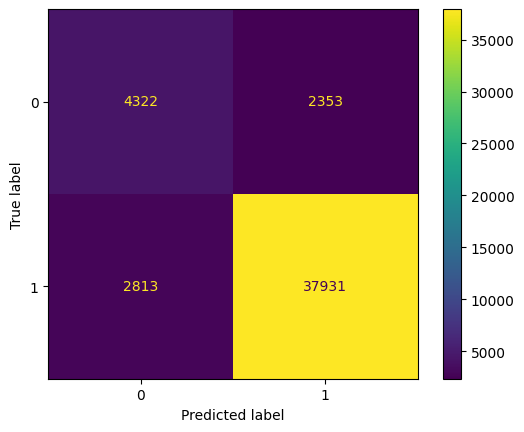

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

## Бустинг

### Просто

In [ ]:
cb_pipeline = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced'))
])

cb_pipeline.fit(X_train['Review'], y_train)

Learning rate set to 0.085564


In [ ]:
pred = cb_pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.53      0.90      0.66      6675
           1       0.98      0.87      0.92     40744

    accuracy                           0.87     47419
   macro avg       0.75      0.88      0.79     47419
weighted avg       0.92      0.87      0.88     47419



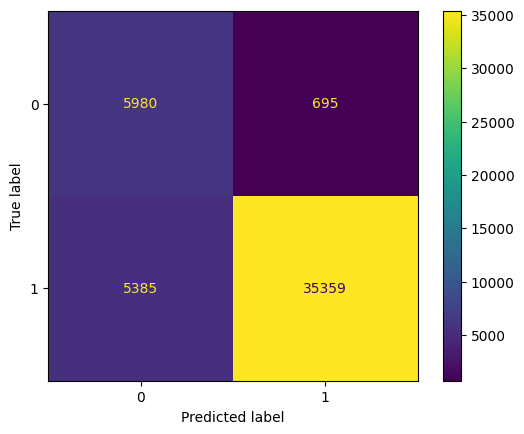

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(cb_pipeline, X_test['Review'], y_test)

### Решим проблему с временем обучения

#### GPU

Cразу дропает коллаб из-за нехватки памяти.

#### Сабсет данных

In [ ]:
small_df = data_clean_russian.sample(frac=0.1, random_state=42)

In [ ]:
small_df = small_df[['Review', 'Sentiment']]
small_df.reset_index(drop=True)

Review  Sentiment
0      мо ошибк невнимательн посмотрел размер нам кат...          1
1      бреет хорош волос не закусыва оста очен мелк щ...          1
2                            замечательн плечик рекоменд          1
3         классн кофт понрав и на мо крупн муж в сам раз          1
4      тапочк очен понрав сво денег сто приятн мягк и...          1
...                                                  ...        ...
18962  внешн вид размер заказа один маломер созда ощу...          0
18963  за сво цен четк врод нет пришел не закручен не...          1
18964  удобн формат мне нрав формат эт средств неболь...          1
18965                     мне подход эт баз бер втор раз          1
18966               отличн лонгсл в размер качеств супер          1

[18967 rows x 2 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(small_df[['Review']],
                                                    small_df['Sentiment'],
                                                    stratify=small_df['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [ ]:
cb_pipeline_default = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', task_type="GPU", verbose=50))
])

cb_pipeline_default.fit(X_train['Review'], y_train)

Learning rate set to 0.029131
0:	learn: 0.6812421	total: 479ms	remaining: 7m 58s
50:	learn: 0.4969777	total: 20.7s	remaining: 6m 25s
100:	learn: 0.4576097	total: 32.7s	remaining: 4m 51s
150:	learn: 0.4353605	total: 43.5s	remaining: 4m 4s
200:	learn: 0.4195226	total: 53.9s	remaining: 3m 34s
250:	learn: 0.4052718	total: 1m 4s	remaining: 3m 13s
300:	learn: 0.3958800	total: 1m 15s	remaining: 2m 55s
350:	learn: 0.3846857	total: 1m 31s	remaining: 2m 48s
400:	learn: 0.3732818	total: 1m 42s	remaining: 2m 33s
450:	learn: 0.3631667	total: 1m 53s	remaining: 2m 18s
500:	learn: 0.3552231	total: 2m 5s	remaining: 2m 4s
550:	learn: 0.3474998	total: 2m 20s	remaining: 1m 54s
600:	learn: 0.3409006	total: 2m 34s	remaining: 1m 42s
650:	learn: 0.3347846	total: 2m 48s	remaining: 1m 30s
700:	learn: 0.3286748	total: 3m 1s	remaining: 1m 17s
750:	learn: 0.3235248	total: 3m 12s	remaining: 1m 3s
800:	learn: 0.3185652	total: 3m 23s	remaining: 50.5s
850:	learn: 0.3153295	total: 3m 33s	remaining: 37.4s
900:	learn: 0.

Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x79e02697ca90>)])

In [ ]:
pred = cb_pipeline_default.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.44      0.89      0.59       664
           1       0.98      0.82      0.89      4078

    accuracy                           0.83      4742
   macro avg       0.71      0.85      0.74      4742
weighted avg       0.90      0.83      0.85      4742



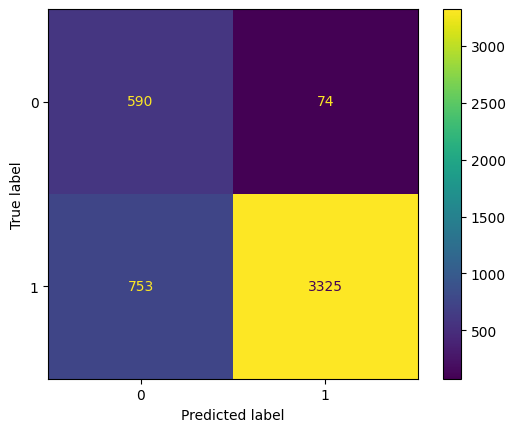

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(cb_pipeline_default, X_test['Review'], y_test)

### Поиграемся с гиперпараметрами

In [ ]:
cb_pipeline = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', CatBoostClassifier(random_state=42,
                               auto_class_weights='Balanced',
                               task_type="GPU",
                               silent=True,
                               early_stopping_rounds=20))
])

param_grid = {
    'tf__max_features': [5000, 10000],  # Оптимальный диапазон для текста
    'clf__iterations': [300],  # Фиксируем, управляем через early_stopping
    'clf__learning_rate': [0.03, 0.05],  # Самые важные для CatBoost
    'clf__depth': [6, 8],  # Оптимальная глубина для текста
    'clf__l2_leaf_reg': [3, 5],  # Регуляризация
}

grid_search = GridSearchCV(
    estimator=cb_pipeline,
    param_grid=param_grid,
    cv=3,  # 3 фолда - оптимально для времени
    scoring='f1_weighted',  # Лучшая метрика для дисбаланса
    n_jobs=1,  # Для CatBoost на GPU важно
    verbose=4  # Подробный вывод прогресса
)

In [ ]:
grid_search.fit(X_train['Review'], y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=5000;, score=0.802 total time=   7.2s
[CV 2/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=5000;, score=0.814 total time=   4.8s
[CV 3/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=5000;, score=0.800 total time=   7.0s
[CV 1/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=10000;, score=0.802 total time=   6.0s
[CV 2/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=10000;, score=0.817 total time=   8.1s
[CV 3/3] END clf__depth=6, clf__iterations=300, clf__l2_leaf_reg=3, clf__learning_rate=0.03, tf__max_features=10000;, score=0.799 total time=   6.2s
[CV 1/3] END clf__depth=6, clf__iterations=300, 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x7d3ca1f09f10>)]),
             n_jobs=1,
             param_grid={'clf__depth': [6, 8], 'clf__iterations': [300],
                         'clf__l2_leaf_reg': [3, 5],
                         'clf__learning_rate': [0.03, 0.05],
                         'tf__max_features': [5000, 10000]},
             scoring='f1_weighted', verbose=4)

In [ ]:
print("Best parameters:", grid_search.best_params_)
pred = grid_search.predict(X_test['Review'])
print(classification_report(y_test, pred))

Best parameters: {'clf__depth': 8, 'clf__iterations': 300, 'clf__l2_leaf_reg': 3, 'clf__learning_rate': 0.05, 'tf__max_features': 5000}
              precision    recall  f1-score   support

           0       0.42      0.88      0.57       664
           1       0.98      0.80      0.88      4078

    accuracy                           0.81      4742
   macro avg       0.70      0.84      0.73      4742
weighted avg       0.90      0.81      0.84      4742



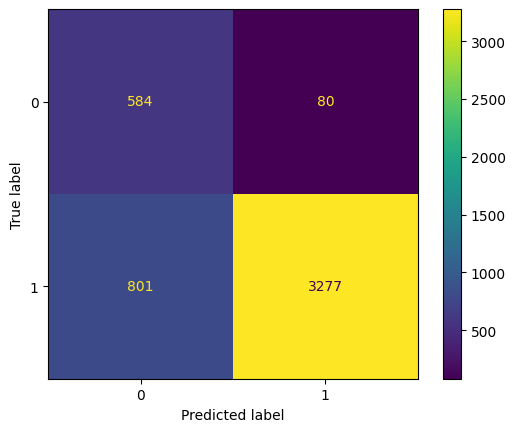

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search, X_test['Review'], y_test)

### Threshold

In [ ]:
thresholds = [0.05*i for i in range(1, 20)]
def threshold_selection(model, test_data, report=True, matrix=True):
    print("Original classification threshold:")
    try:
        original_threshold = model.named_steps['clf'].get_probability_threshold()
    except AttributeError:
        original_threshold = model.get_probability_threshold()
    print(original_threshold)
    for threshold in thresholds:
        print(f"====== threshold={threshold} ======")
        try:
            model.named_steps['clf'].set_probability_threshold(threshold)
        except AttributeError:
            model.set_probability_threshold(threshold)
        if report:
            pred = model.predict(test_data)
            print(classification_report(y_test, pred))
            print()
        if matrix:
            ConfusionMatrixDisplay.from_estimator(model, test_data, y_test)
            plt.show()
            print()
    try:
        model.named_steps['clf'].set_probability_threshold(original_threshold)
    except AttributeError:
        model.set_probability_threshold(original_threshold)

#### Для обычного

Original classification threshold:
0.5
====== threshold=0.05 ======
              precision    recall  f1-score   support

           0       0.93      0.06      0.12       664
           1       0.87      1.00      0.93      4078

    accuracy                           0.87      4742
   macro avg       0.90      0.53      0.53      4742
weighted avg       0.88      0.87      0.82      4742




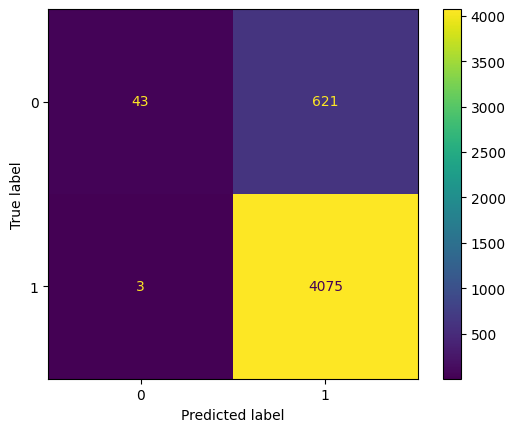


====== threshold=0.1 ======
              precision    recall  f1-score   support

           0       0.85      0.23      0.36       664
           1       0.89      0.99      0.94      4078

    accuracy                           0.89      4742
   macro avg       0.87      0.61      0.65      4742
weighted avg       0.88      0.89      0.86      4742




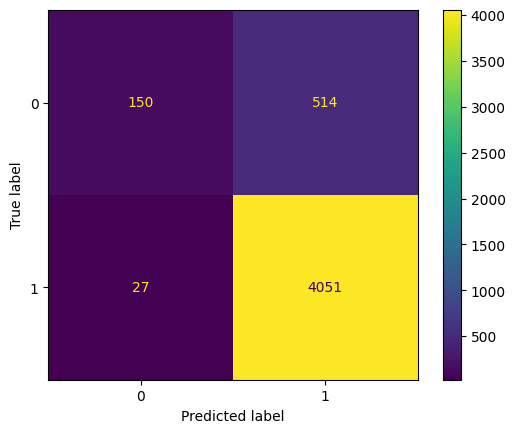


====== threshold=0.15000000000000002 ======
              precision    recall  f1-score   support

           0       0.81      0.39      0.53       664
           1       0.91      0.99      0.95      4078

    accuracy                           0.90      4742
   macro avg       0.86      0.69      0.74      4742
weighted avg       0.89      0.90      0.89      4742




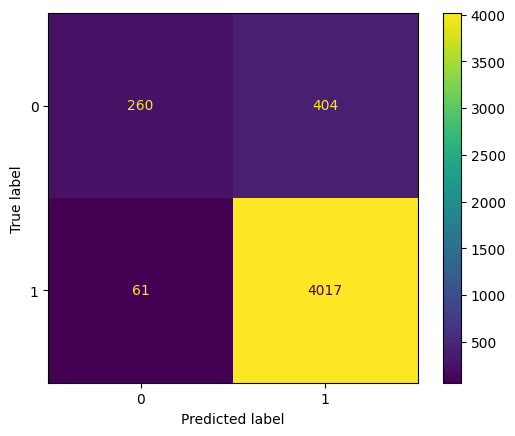


====== threshold=0.2 ======
              precision    recall  f1-score   support

           0       0.73      0.49      0.59       664
           1       0.92      0.97      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.82      0.73      0.77      4742
weighted avg       0.89      0.90      0.89      4742




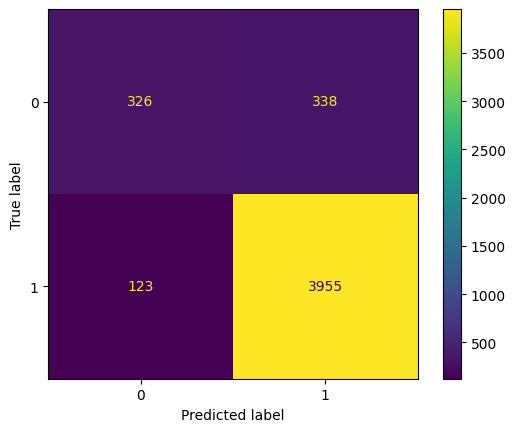


====== threshold=0.25 ======
              precision    recall  f1-score   support

           0       0.70      0.58      0.63       664
           1       0.93      0.96      0.95      4078

    accuracy                           0.91      4742
   macro avg       0.81      0.77      0.79      4742
weighted avg       0.90      0.91      0.90      4742




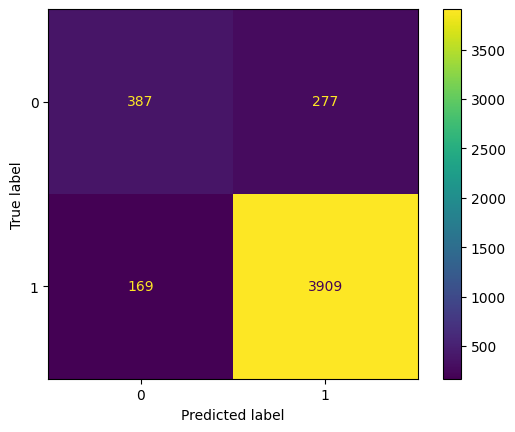


====== threshold=0.30000000000000004 ======
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       664
           1       0.94      0.94      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.80      0.80      0.80      4742
weighted avg       0.90      0.90      0.90      4742




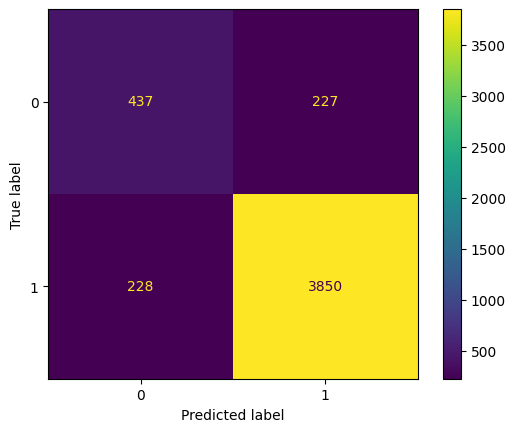


====== threshold=0.35000000000000003 ======
              precision    recall  f1-score   support

           0       0.63      0.72      0.67       664
           1       0.95      0.93      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.79      0.82      0.80      4742
weighted avg       0.91      0.90      0.90      4742




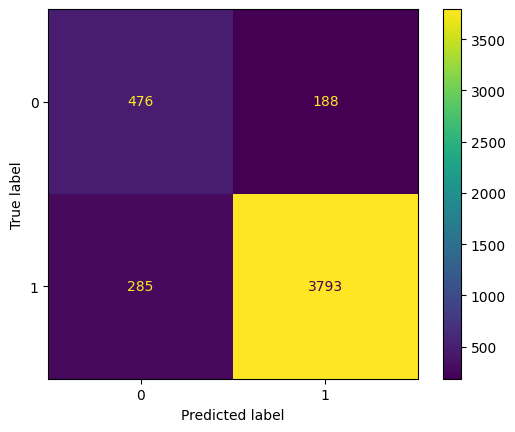


====== threshold=0.4 ======
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       664
           1       0.96      0.91      0.93      4078

    accuracy                           0.89      4742
   macro avg       0.77      0.84      0.80      4742
weighted avg       0.91      0.89      0.90      4742




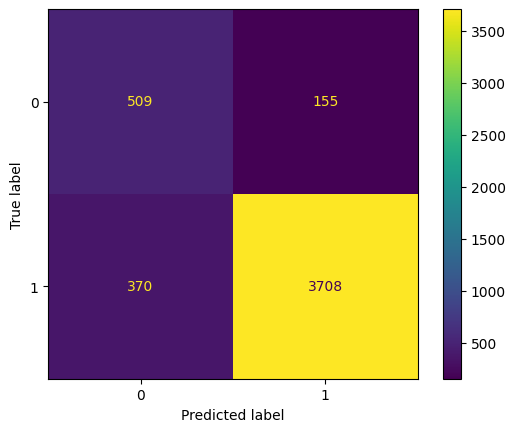


====== threshold=0.45 ======
              precision    recall  f1-score   support

           0       0.49      0.85      0.62       664
           1       0.97      0.86      0.91      4078

    accuracy                           0.85      4742
   macro avg       0.73      0.85      0.77      4742
weighted avg       0.90      0.85      0.87      4742




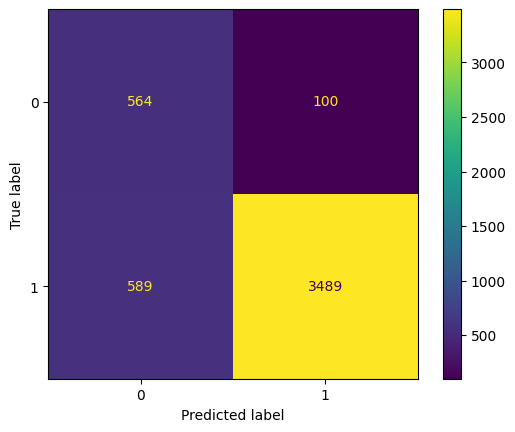


====== threshold=0.5 ======
              precision    recall  f1-score   support

           0       0.44      0.89      0.59       664
           1       0.98      0.82      0.89      4078

    accuracy                           0.83      4742
   macro avg       0.71      0.85      0.74      4742
weighted avg       0.90      0.83      0.85      4742




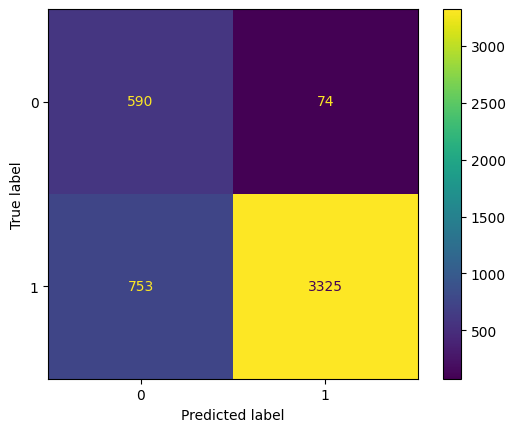


====== threshold=0.55 ======
              precision    recall  f1-score   support

           0       0.42      0.90      0.57       664
           1       0.98      0.80      0.88      4078

    accuracy                           0.81      4742
   macro avg       0.70      0.85      0.72      4742
weighted avg       0.90      0.81      0.83      4742




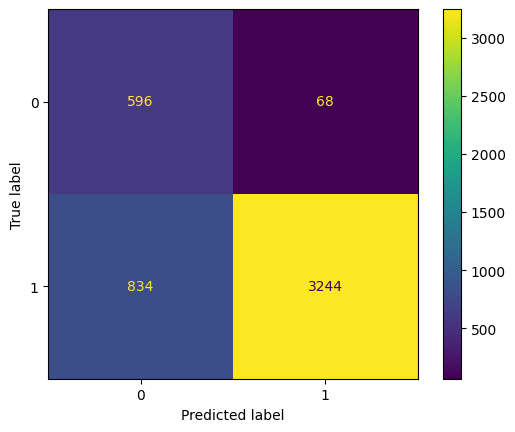


====== threshold=0.6000000000000001 ======
              precision    recall  f1-score   support

           0       0.39      0.91      0.55       664
           1       0.98      0.77      0.86      4078

    accuracy                           0.79      4742
   macro avg       0.69      0.84      0.71      4742
weighted avg       0.90      0.79      0.82      4742




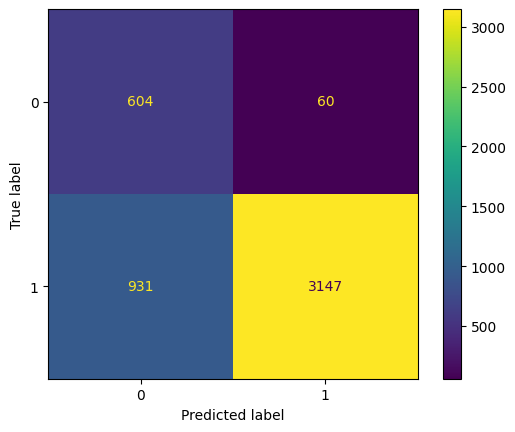


====== threshold=0.65 ======
              precision    recall  f1-score   support

           0       0.36      0.91      0.52       664
           1       0.98      0.74      0.84      4078

    accuracy                           0.76      4742
   macro avg       0.67      0.83      0.68      4742
weighted avg       0.89      0.76      0.80      4742




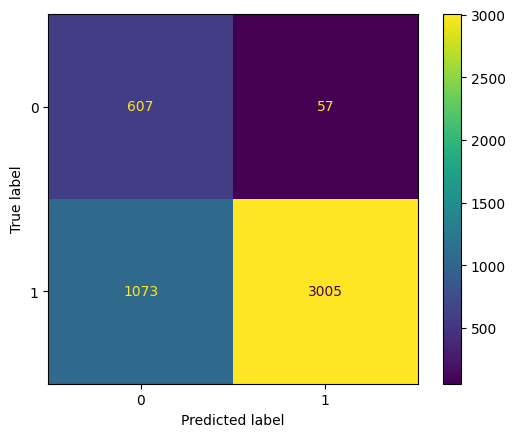


====== threshold=0.7000000000000001 ======
              precision    recall  f1-score   support

           0       0.34      0.92      0.50       664
           1       0.98      0.71      0.82      4078

    accuracy                           0.74      4742
   macro avg       0.66      0.81      0.66      4742
weighted avg       0.89      0.74      0.78      4742




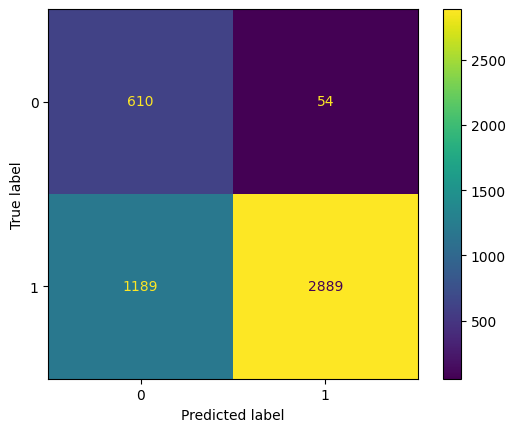


====== threshold=0.75 ======
              precision    recall  f1-score   support

           0       0.32      0.93      0.48       664
           1       0.98      0.68      0.80      4078

    accuracy                           0.71      4742
   macro avg       0.65      0.81      0.64      4742
weighted avg       0.89      0.71      0.76      4742




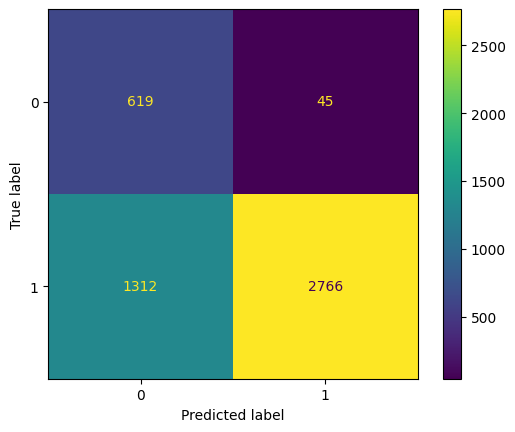


====== threshold=0.8 ======
              precision    recall  f1-score   support

           0       0.29      0.95      0.45       664
           1       0.99      0.63      0.77      4078

    accuracy                           0.67      4742
   macro avg       0.64      0.79      0.61      4742
weighted avg       0.89      0.67      0.72      4742




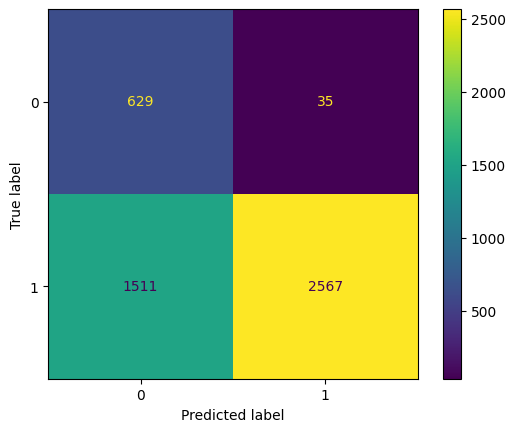


====== threshold=0.8500000000000001 ======
              precision    recall  f1-score   support

           0       0.27      0.95      0.42       664
           1       0.99      0.57      0.72      4078

    accuracy                           0.62      4742
   macro avg       0.63      0.76      0.57      4742
weighted avg       0.89      0.62      0.68      4742




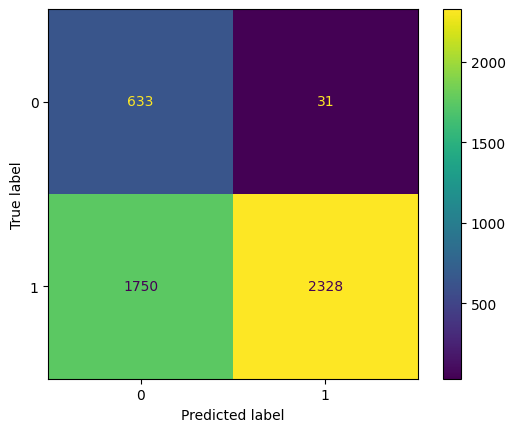


====== threshold=0.9 ======
              precision    recall  f1-score   support

           0       0.23      0.97      0.37       664
           1       0.99      0.48      0.65      4078

    accuracy                           0.55      4742
   macro avg       0.61      0.72      0.51      4742
weighted avg       0.88      0.55      0.61      4742




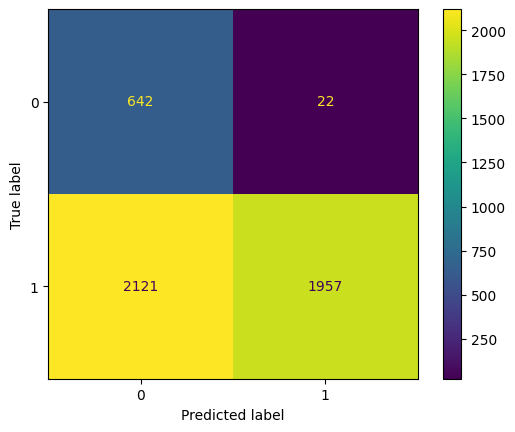


====== threshold=0.9500000000000001 ======
              precision    recall  f1-score   support

           0       0.18      0.98      0.31       664
           1       0.99      0.28      0.44      4078

    accuracy                           0.38      4742
   macro avg       0.58      0.63      0.37      4742
weighted avg       0.88      0.38      0.42      4742




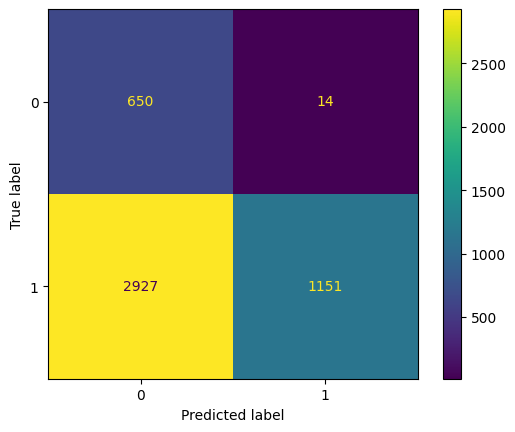

In [ ]:
threshold_selection(cb_pipeline_default, X_test['Review'])

#### С параметрами

Original classification threshold:
0.05
====== threshold=0.05 ======
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       664
           1       0.86      1.00      0.93      4078

    accuracy                           0.86      4742
   macro avg       0.93      0.51      0.48      4742
weighted avg       0.88      0.86      0.80      4742




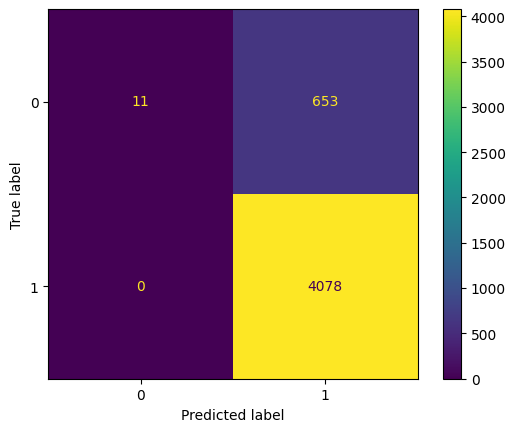


====== threshold=0.1 ======
              precision    recall  f1-score   support

           0       0.87      0.10      0.18       664
           1       0.87      1.00      0.93      4078

    accuracy                           0.87      4742
   macro avg       0.87      0.55      0.55      4742
weighted avg       0.87      0.87      0.83      4742




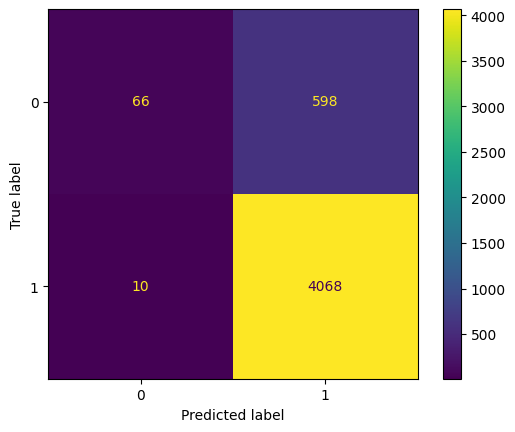


====== threshold=0.15000000000000002 ======
              precision    recall  f1-score   support

           0       0.81      0.27      0.40       664
           1       0.89      0.99      0.94      4078

    accuracy                           0.89      4742
   macro avg       0.85      0.63      0.67      4742
weighted avg       0.88      0.89      0.86      4742




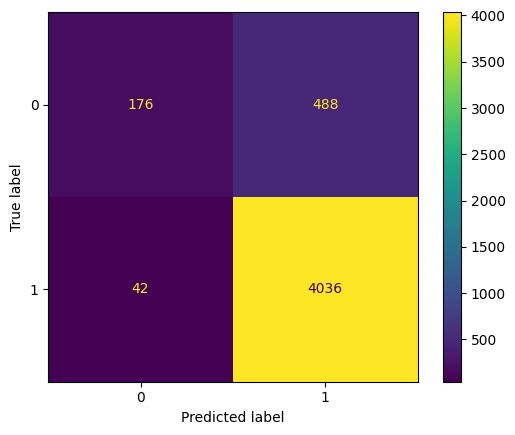


====== threshold=0.2 ======
              precision    recall  f1-score   support

           0       0.74      0.40      0.52       664
           1       0.91      0.98      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.82      0.69      0.73      4742
weighted avg       0.89      0.90      0.88      4742




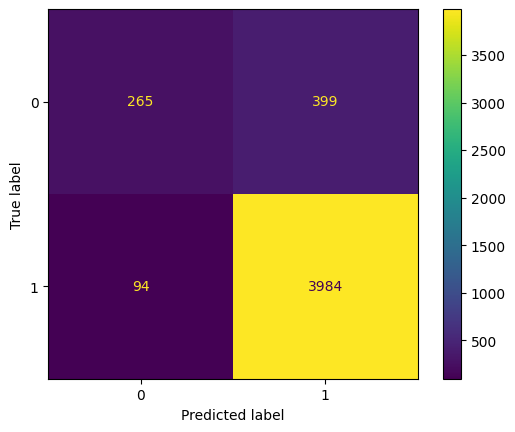


====== threshold=0.25 ======
              precision    recall  f1-score   support

           0       0.68      0.52      0.59       664
           1       0.92      0.96      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.80      0.74      0.77      4742
weighted avg       0.89      0.90      0.89      4742




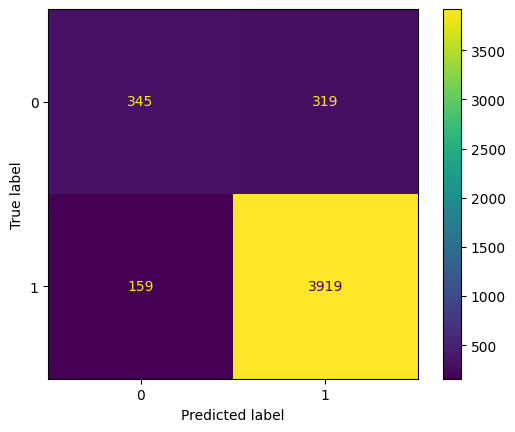


====== threshold=0.30000000000000004 ======
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       664
           1       0.94      0.94      0.94      4078

    accuracy                           0.90      4742
   macro avg       0.79      0.78      0.79      4742
weighted avg       0.90      0.90      0.90      4742




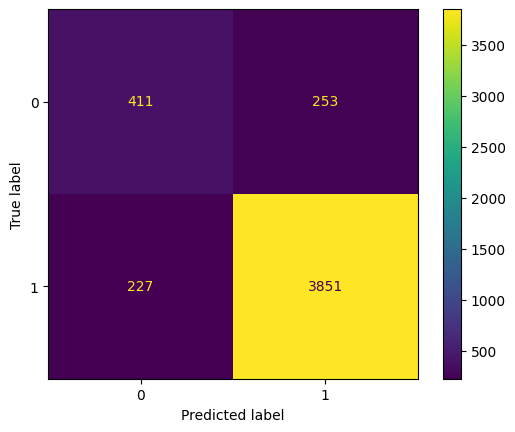


====== threshold=0.35000000000000003 ======
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       664
           1       0.95      0.93      0.94      4078

    accuracy                           0.89      4742
   macro avg       0.77      0.80      0.79      4742
weighted avg       0.90      0.89      0.89      4742




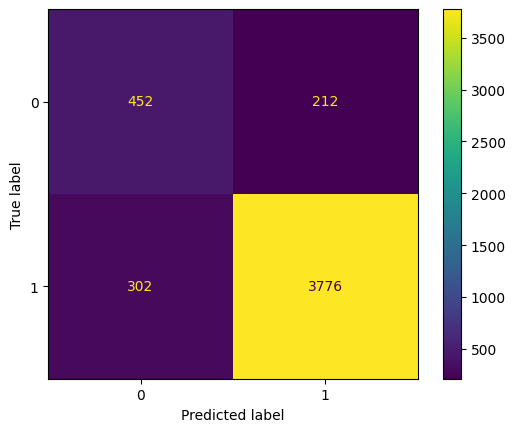


====== threshold=0.4 ======
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       664
           1       0.96      0.90      0.93      4078

    accuracy                           0.88      4742
   macro avg       0.75      0.82      0.78      4742
weighted avg       0.90      0.88      0.89      4742




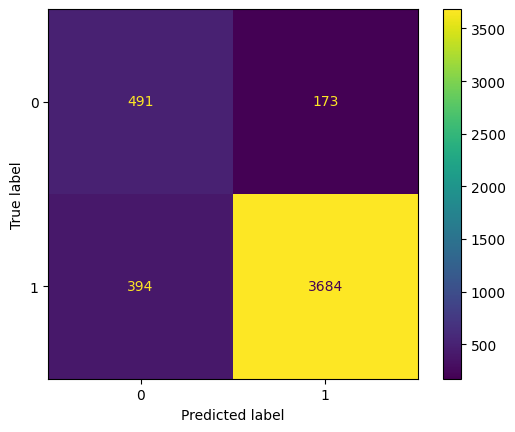


====== threshold=0.45 ======
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       664
           1       0.97      0.87      0.92      4078

    accuracy                           0.86      4742
   macro avg       0.73      0.84      0.77      4742
weighted avg       0.90      0.86      0.87      4742




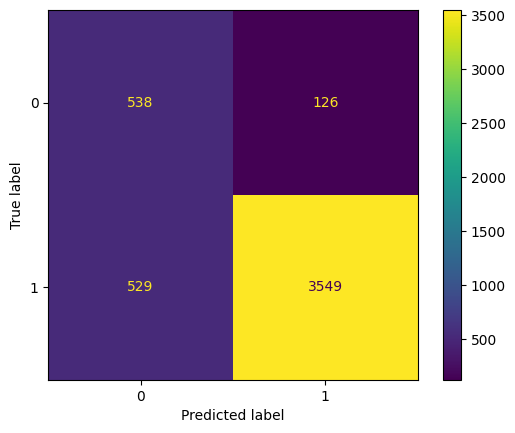


====== threshold=0.5 ======
              precision    recall  f1-score   support

           0       0.42      0.88      0.57       664
           1       0.98      0.80      0.88      4078

    accuracy                           0.81      4742
   macro avg       0.70      0.84      0.73      4742
weighted avg       0.90      0.81      0.84      4742




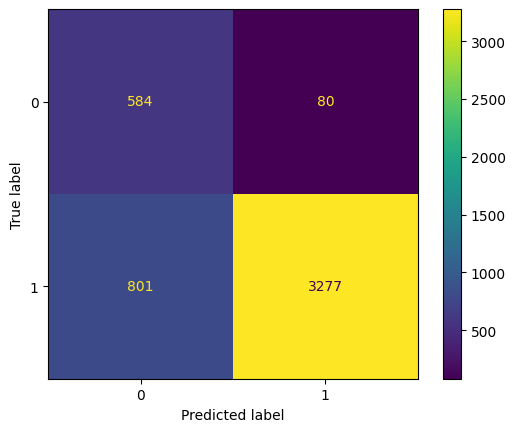


====== threshold=0.55 ======
              precision    recall  f1-score   support

           0       0.39      0.90      0.54       664
           1       0.98      0.77      0.86      4078

    accuracy                           0.79      4742
   macro avg       0.68      0.83      0.70      4742
weighted avg       0.90      0.79      0.82      4742




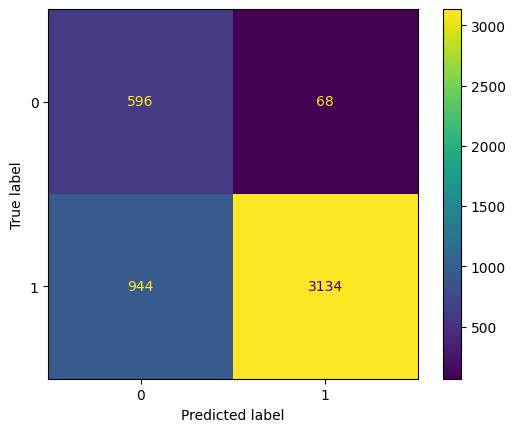


====== threshold=0.6000000000000001 ======
              precision    recall  f1-score   support

           0       0.36      0.90      0.51       664
           1       0.98      0.74      0.84      4078

    accuracy                           0.76      4742
   macro avg       0.67      0.82      0.68      4742
weighted avg       0.89      0.76      0.79      4742




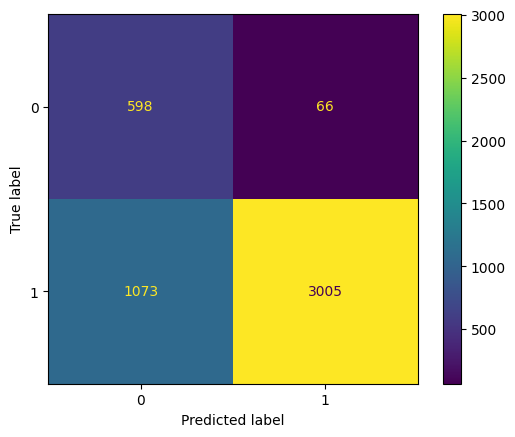


====== threshold=0.65 ======
              precision    recall  f1-score   support

           0       0.33      0.92      0.49       664
           1       0.98      0.70      0.82      4078

    accuracy                           0.73      4742
   macro avg       0.66      0.81      0.65      4742
weighted avg       0.89      0.73      0.77      4742




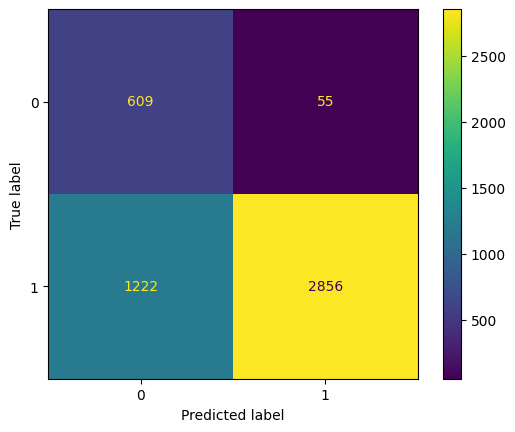


====== threshold=0.7000000000000001 ======
              precision    recall  f1-score   support

           0       0.31      0.93      0.46       664
           1       0.98      0.66      0.79      4078

    accuracy                           0.70      4742
   macro avg       0.65      0.79      0.63      4742
weighted avg       0.89      0.70      0.74      4742




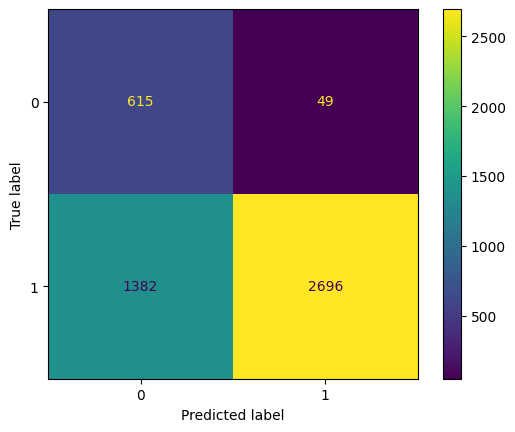


====== threshold=0.75 ======
              precision    recall  f1-score   support

           0       0.29      0.95      0.45       664
           1       0.99      0.63      0.77      4078

    accuracy                           0.67      4742
   macro avg       0.64      0.79      0.61      4742
weighted avg       0.89      0.67      0.72      4742




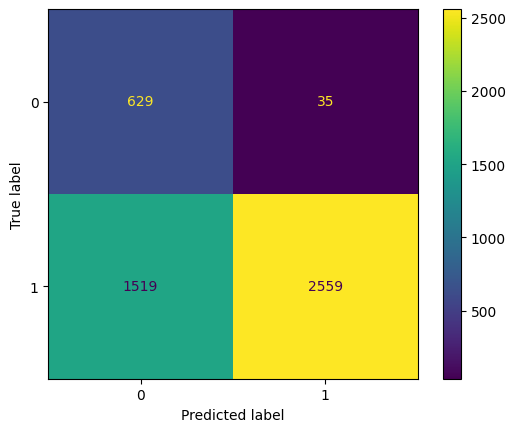


====== threshold=0.8 ======
              precision    recall  f1-score   support

           0       0.27      0.96      0.42       664
           1       0.99      0.57      0.73      4078

    accuracy                           0.63      4742
   macro avg       0.63      0.77      0.57      4742
weighted avg       0.89      0.63      0.68      4742




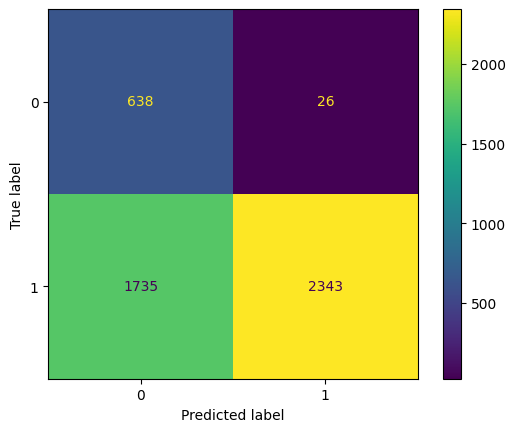


====== threshold=0.8500000000000001 ======
              precision    recall  f1-score   support

           0       0.24      0.97      0.39       664
           1       0.99      0.51      0.67      4078

    accuracy                           0.57      4742
   macro avg       0.62      0.74      0.53      4742
weighted avg       0.89      0.57      0.63      4742




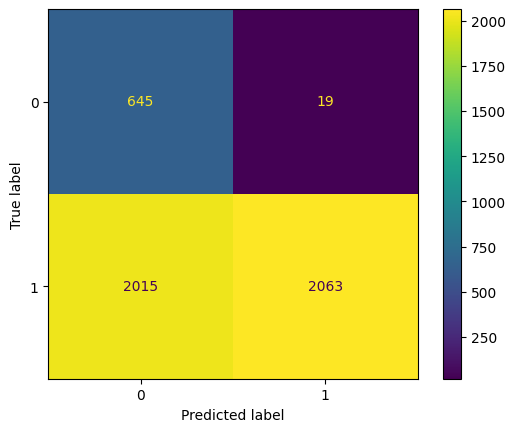


====== threshold=0.9 ======
              precision    recall  f1-score   support

           0       0.21      0.98      0.35       664
           1       0.99      0.42      0.59      4078

    accuracy                           0.49      4742
   macro avg       0.60      0.70      0.47      4742
weighted avg       0.88      0.49      0.55      4742




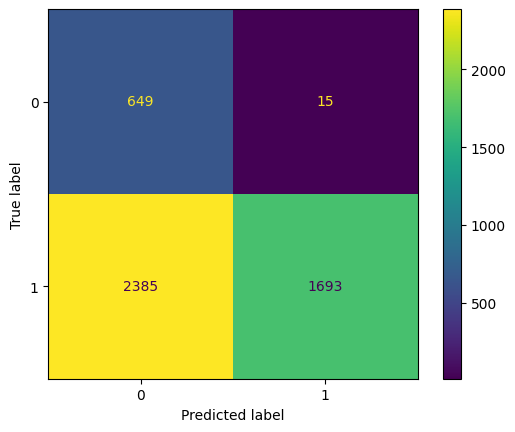


====== threshold=0.9500000000000001 ======
              precision    recall  f1-score   support

           0       0.17      0.99      0.29       664
           1       0.99      0.20      0.33      4078

    accuracy                           0.31      4742
   macro avg       0.58      0.59      0.31      4742
weighted avg       0.87      0.31      0.32      4742




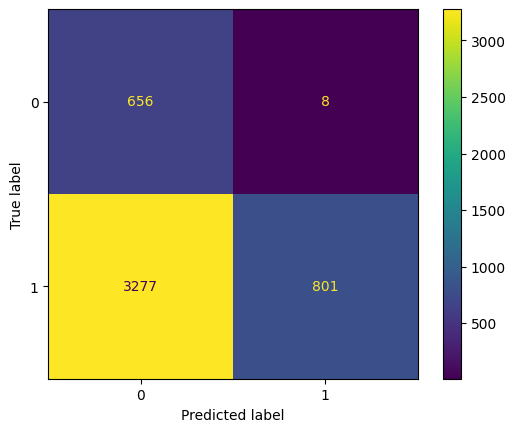

In [ ]:
threshold_selection(grid_search.best_estimator_, X_test['Review'])

### rubert-tiny2 + catboost

#### Проба пера

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2").to("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True,
                          max_length=256, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings)

In [ ]:
small_df_nostem = data_clean.sample(frac=0.1, random_state=42)

In [ ]:
small_df_nostem = small_df_nostem[['Review', 'Sentiment']]
small_df_nostem.reset_index(drop=True)

Review  Sentiment
0                    Заряжает быстро  Разряжается быстро          1
1      Шлепанцы маломерят берите сразу на размер боль...          1
2                                             Слабенькие          0
3                                 Маленькая, но удобная.          1
4      Нашла для себя лучшие станки, беру не в первый...          1
...                                                  ...        ...
19164  Хороший, качественный, но рисунок бледный, как...          0
19165                          Шумит сильно, и протикает          0
19166                               Полное некачественно          0
19167  Брала в подарок, ещё не пользовались. Оформлен...          1
19168                                         Рекомендую          1

[19169 rows x 2 columns]

In [ ]:
texts = small_df_nostem['Review'].astype(str).tolist()
start_time = time.time()
embeddings = get_embeddings(texts)
print(f"{time.time() - start_time:.2f} sec")

6.95 sec


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    small_df_nostem['Sentiment'],
    test_size=0.25,
    stratify=small_df_nostem['Sentiment'],
    random_state=42
)

In [ ]:
cat_rubert_emb = CatBoostClassifier(random_state=42, auto_class_weights='Balanced', task_type="GPU", verbose=50)

In [ ]:
cat_rubert_emb.fit(X_train, y_train)

Learning rate set to 0.029114
0:	learn: 0.6814031	total: 101ms	remaining: 1m 40s
50:	learn: 0.4493221	total: 2.69s	remaining: 50s
100:	learn: 0.3931576	total: 5.16s	remaining: 45.9s
150:	learn: 0.3647254	total: 8.3s	remaining: 46.6s
200:	learn: 0.3445499	total: 11.2s	remaining: 44.3s
250:	learn: 0.3278314	total: 13.6s	remaining: 40.5s
300:	learn: 0.3140733	total: 15.9s	remaining: 37s
350:	learn: 0.3014175	total: 18.3s	remaining: 33.8s
400:	learn: 0.2896617	total: 21.2s	remaining: 31.6s
450:	learn: 0.2789230	total: 23.8s	remaining: 29s
500:	learn: 0.2687108	total: 26.2s	remaining: 26.1s
550:	learn: 0.2600410	total: 28.5s	remaining: 23.2s
600:	learn: 0.2513310	total: 30.9s	remaining: 20.5s
650:	learn: 0.2428643	total: 33.9s	remaining: 18.2s
700:	learn: 0.2348553	total: 36.7s	remaining: 15.7s
750:	learn: 0.2275698	total: 39.1s	remaining: 13s
800:	learn: 0.2206191	total: 41.4s	remaining: 10.3s
850:	learn: 0.2145349	total: 43.8s	remaining: 7.67s
900:	learn: 0.2080646	total: 46.4s	remaining:

In [ ]:
pred = cat_rubert_emb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61       672
           1       0.96      0.87      0.91      4121

    accuracy                           0.86      4793
   macro avg       0.73      0.82      0.76      4793
weighted avg       0.90      0.86      0.87      4793



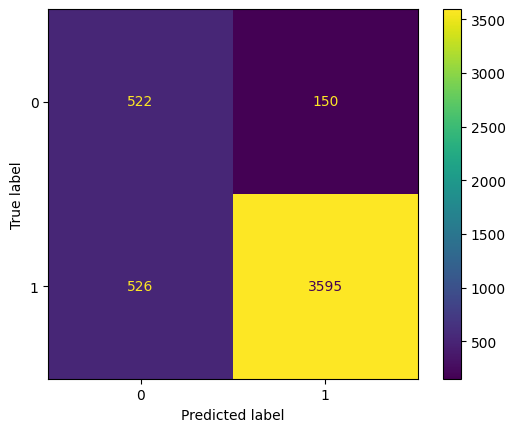

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(cat_rubert_emb, X_test, y_test)

#### Threshold

Original classification threshold:
0.5
====== threshold=0.05 ======
              precision    recall  f1-score   support

           0       0.68      0.03      0.07       672
           1       0.86      1.00      0.93      4121

    accuracy                           0.86      4793
   macro avg       0.77      0.52      0.50      4793
weighted avg       0.84      0.86      0.81      4793




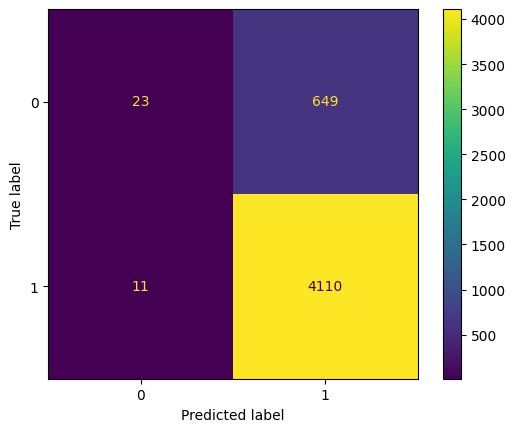


====== threshold=0.1 ======
              precision    recall  f1-score   support

           0       0.73      0.18      0.29       672
           1       0.88      0.99      0.93      4121

    accuracy                           0.88      4793
   macro avg       0.80      0.59      0.61      4793
weighted avg       0.86      0.88      0.84      4793




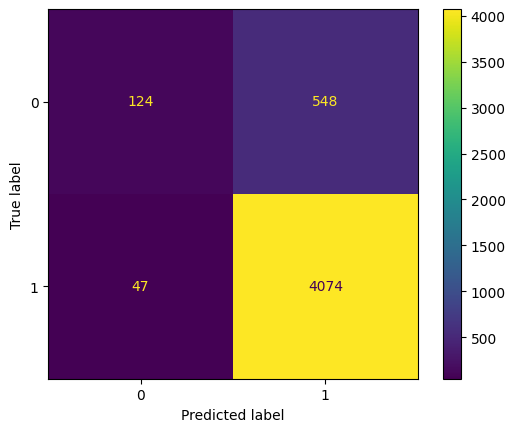


====== threshold=0.15000000000000002 ======
              precision    recall  f1-score   support

           0       0.69      0.33      0.45       672
           1       0.90      0.98      0.94      4121

    accuracy                           0.89      4793
   macro avg       0.80      0.65      0.69      4793
weighted avg       0.87      0.89      0.87      4793




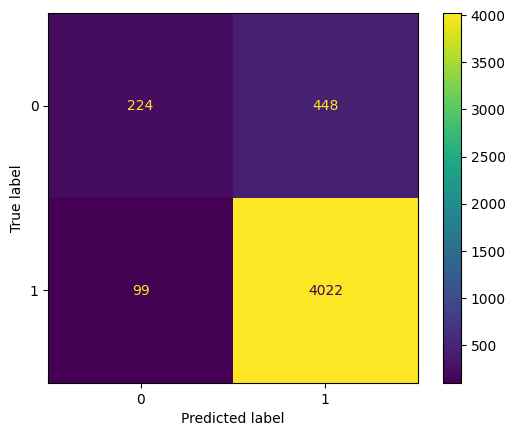


====== threshold=0.2 ======
              precision    recall  f1-score   support

           0       0.67      0.45      0.53       672
           1       0.91      0.96      0.94      4121

    accuracy                           0.89      4793
   macro avg       0.79      0.70      0.74      4793
weighted avg       0.88      0.89      0.88      4793




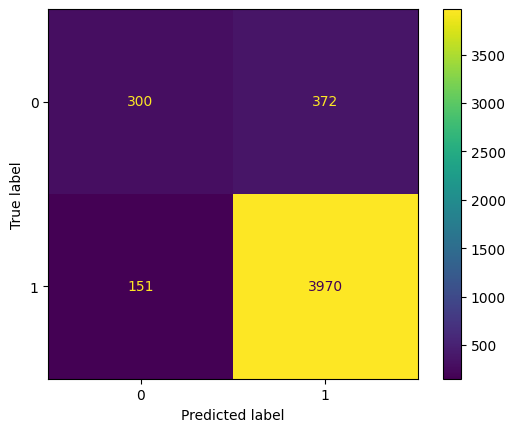


====== threshold=0.25 ======
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       672
           1       0.92      0.95      0.94      4121

    accuracy                           0.89      4793
   macro avg       0.78      0.74      0.76      4793
weighted avg       0.88      0.89      0.89      4793




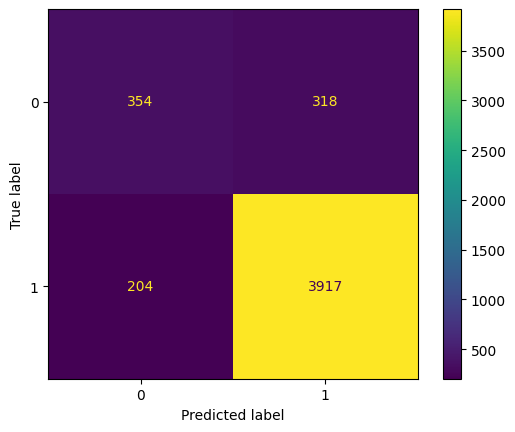


====== threshold=0.30000000000000004 ======
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       672
           1       0.93      0.94      0.93      4121

    accuracy                           0.89      4793
   macro avg       0.77      0.76      0.76      4793
weighted avg       0.89      0.89      0.89      4793




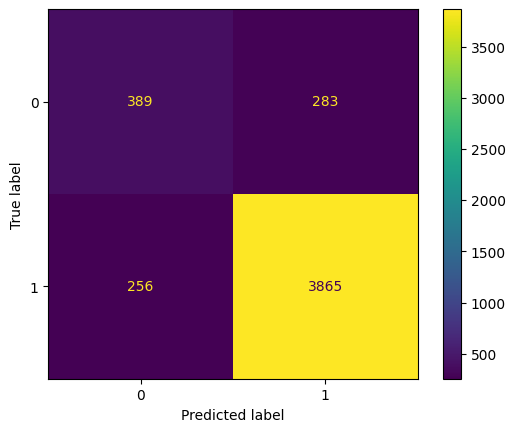


====== threshold=0.35000000000000003 ======
              precision    recall  f1-score   support

           0       0.57      0.64      0.61       672
           1       0.94      0.92      0.93      4121

    accuracy                           0.88      4793
   macro avg       0.76      0.78      0.77      4793
weighted avg       0.89      0.88      0.89      4793




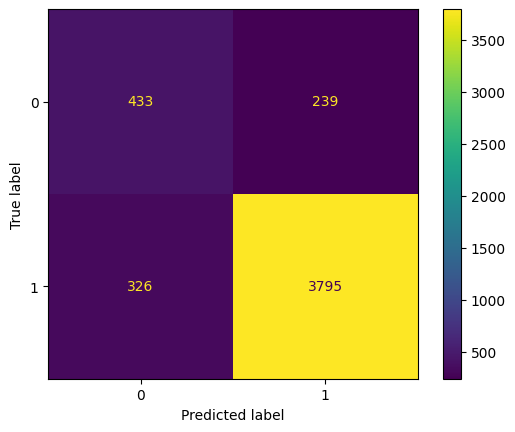


====== threshold=0.4 ======
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       672
           1       0.95      0.91      0.93      4121

    accuracy                           0.88      4793
   macro avg       0.75      0.80      0.77      4793
weighted avg       0.89      0.88      0.88      4793




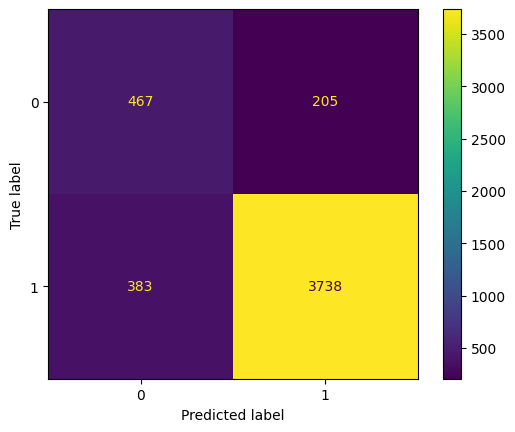


====== threshold=0.45 ======
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       672
           1       0.95      0.89      0.92      4121

    accuracy                           0.87      4793
   macro avg       0.74      0.81      0.77      4793
weighted avg       0.89      0.87      0.88      4793




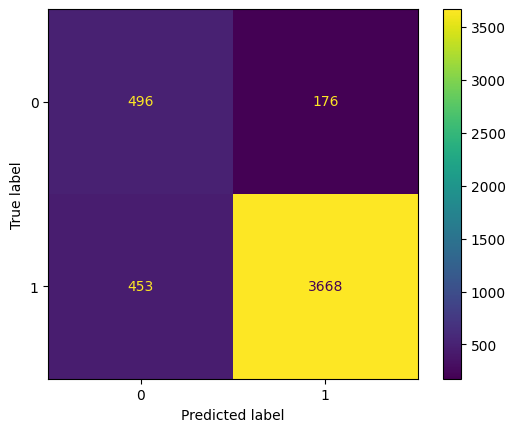


====== threshold=0.5 ======
              precision    recall  f1-score   support

           0       0.50      0.78      0.61       672
           1       0.96      0.87      0.91      4121

    accuracy                           0.86      4793
   macro avg       0.73      0.82      0.76      4793
weighted avg       0.90      0.86      0.87      4793




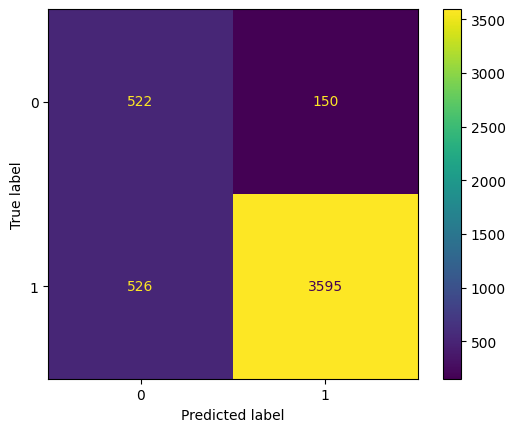


====== threshold=0.55 ======
              precision    recall  f1-score   support

           0       0.47      0.81      0.60       672
           1       0.97      0.85      0.90      4121

    accuracy                           0.85      4793
   macro avg       0.72      0.83      0.75      4793
weighted avg       0.90      0.85      0.86      4793




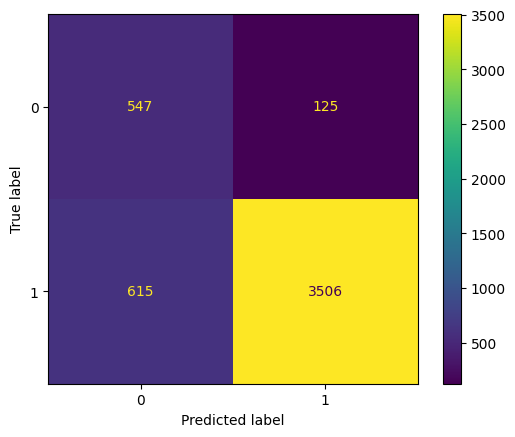


====== threshold=0.6000000000000001 ======
              precision    recall  f1-score   support

           0       0.44      0.84      0.58       672
           1       0.97      0.83      0.89      4121

    accuracy                           0.83      4793
   macro avg       0.70      0.83      0.73      4793
weighted avg       0.89      0.83      0.85      4793




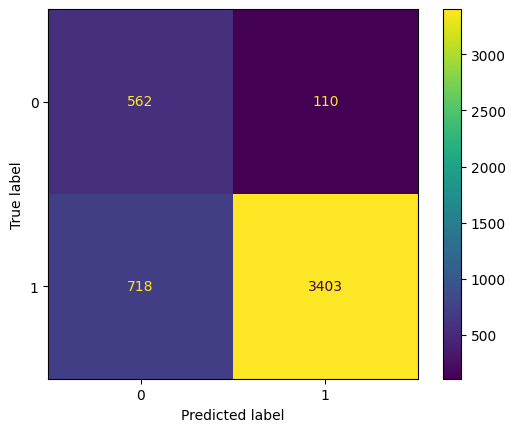


====== threshold=0.65 ======
              precision    recall  f1-score   support

           0       0.41      0.86      0.56       672
           1       0.97      0.80      0.88      4121

    accuracy                           0.81      4793
   macro avg       0.69      0.83      0.72      4793
weighted avg       0.89      0.81      0.83      4793




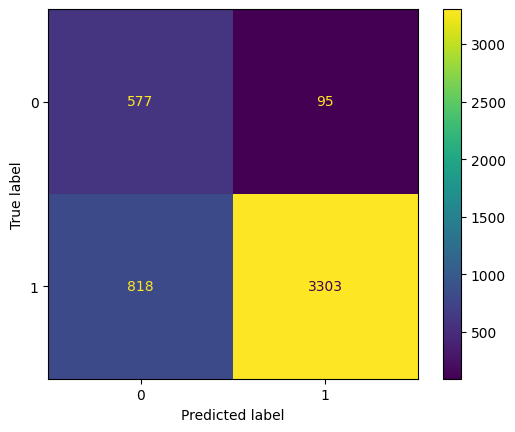


====== threshold=0.7000000000000001 ======
              precision    recall  f1-score   support

           0       0.39      0.89      0.54       672
           1       0.98      0.78      0.86      4121

    accuracy                           0.79      4793
   macro avg       0.68      0.83      0.70      4793
weighted avg       0.89      0.79      0.82      4793




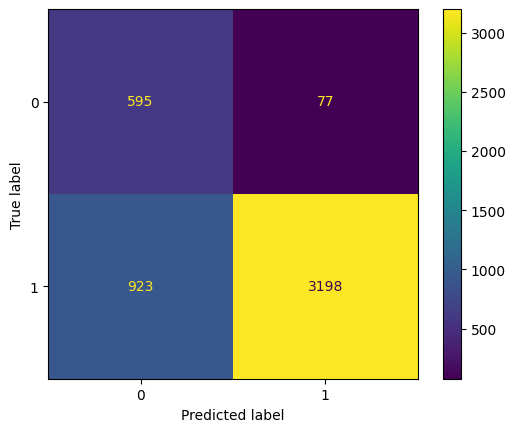


====== threshold=0.75 ======
              precision    recall  f1-score   support

           0       0.37      0.90      0.52       672
           1       0.98      0.75      0.85      4121

    accuracy                           0.77      4793
   macro avg       0.67      0.82      0.68      4793
weighted avg       0.89      0.77      0.80      4793




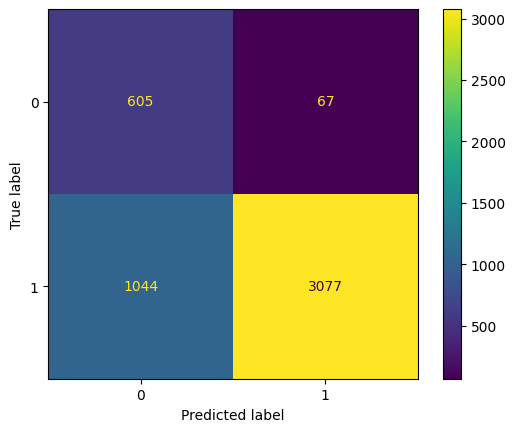


====== threshold=0.8 ======
              precision    recall  f1-score   support

           0       0.35      0.93      0.50       672
           1       0.98      0.71      0.83      4121

    accuracy                           0.74      4793
   macro avg       0.67      0.82      0.67      4793
weighted avg       0.90      0.74      0.78      4793




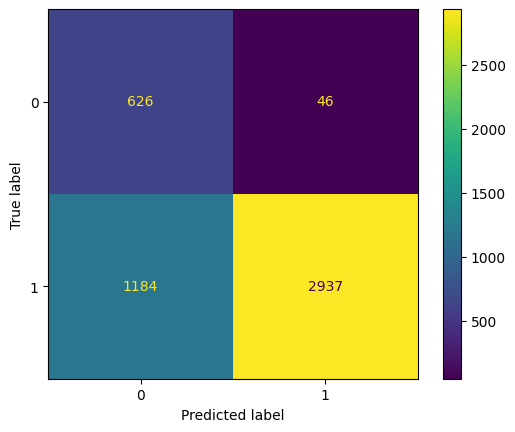


====== threshold=0.8500000000000001 ======
              precision    recall  f1-score   support

           0       0.32      0.95      0.48       672
           1       0.99      0.67      0.80      4121

    accuracy                           0.71      4793
   macro avg       0.65      0.81      0.64      4793
weighted avg       0.89      0.71      0.75      4793




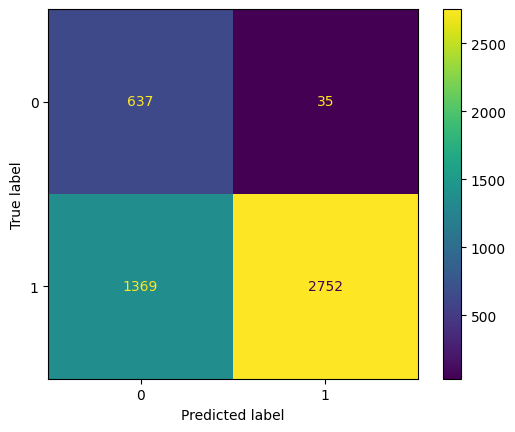


====== threshold=0.9 ======
              precision    recall  f1-score   support

           0       0.28      0.97      0.43       672
           1       0.99      0.58      0.73      4121

    accuracy                           0.64      4793
   macro avg       0.63      0.78      0.58      4793
weighted avg       0.89      0.64      0.69      4793




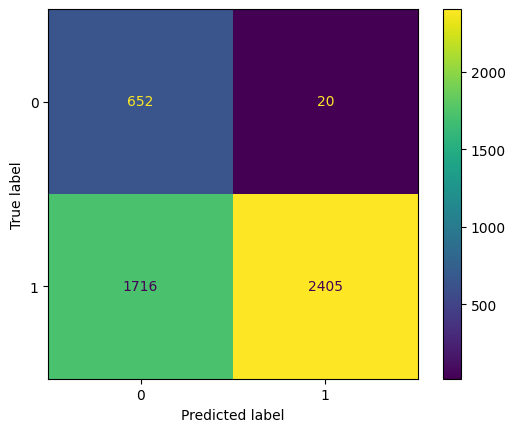


====== threshold=0.9500000000000001 ======
              precision    recall  f1-score   support

           0       0.23      0.98      0.38       672
           1       0.99      0.47      0.64      4121

    accuracy                           0.54      4793
   macro avg       0.61      0.73      0.51      4793
weighted avg       0.89      0.54      0.60      4793




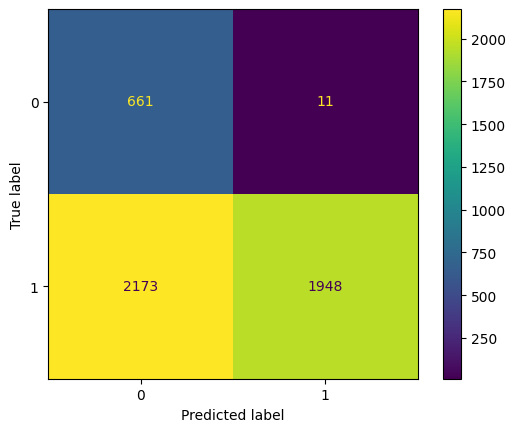

In [ ]:
threshold_selection(cat_rubert_emb, X_test)

## Ансамбли

### Лучший catboost + baseline

#### Обучение на всём датасете

Обучим лучшую конфигурацию catboost'a на всех данных (так как будет комбинировать с baseline'ом)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [ ]:
cb_pipeline_default_full = Pipeline([
    ('tf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose=50))
])

cb_pipeline_default_full.fit(X_train['Review'], y_train)

In [ ]:
pred = cb_pipeline_default_full.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.53      0.90      0.66      6675
           1       0.98      0.87      0.92     40744

    accuracy                           0.87     47419
   macro avg       0.75      0.88      0.79     47419
weighted avg       0.92      0.87      0.88     47419



Original classification threshold:
0.5
====== threshold=0.05 ======
              precision    recall  f1-score   support

           0       0.91      0.20      0.33      6675
           1       0.88      1.00      0.94     40744

    accuracy                           0.88     47419
   macro avg       0.90      0.60      0.63     47419
weighted avg       0.89      0.88      0.85     47419




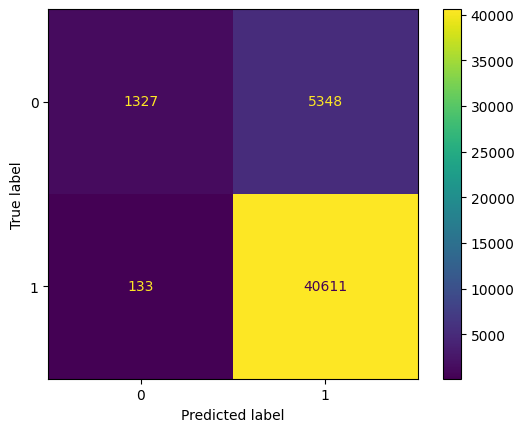


====== threshold=0.1 ======
              precision    recall  f1-score   support

           0       0.85      0.39      0.54      6675
           1       0.91      0.99      0.95     40744

    accuracy                           0.90     47419
   macro avg       0.88      0.69      0.74     47419
weighted avg       0.90      0.90      0.89     47419




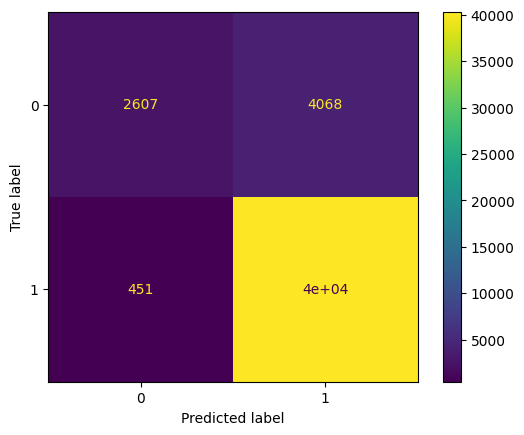


====== threshold=0.15000000000000002 ======
              precision    recall  f1-score   support

           0       0.80      0.53      0.64      6675
           1       0.93      0.98      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.86      0.76      0.80     47419
weighted avg       0.91      0.92      0.91     47419




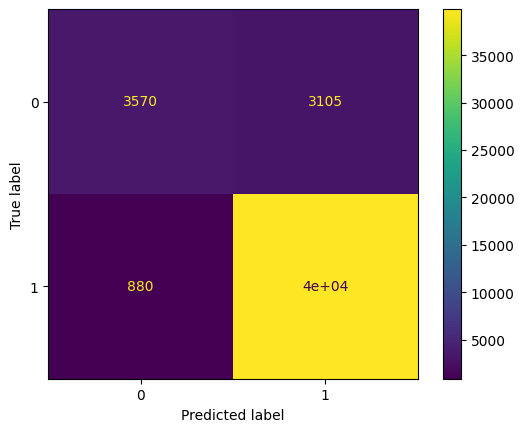


====== threshold=0.2 ======
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      6675
           1       0.94      0.97      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.85      0.80      0.82     47419
weighted avg       0.92      0.92      0.92     47419




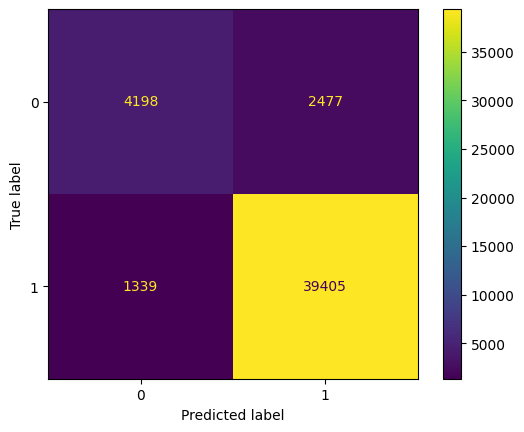


====== threshold=0.25 ======
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      6675
           1       0.95      0.95      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.83      0.83     47419
weighted avg       0.92      0.92      0.92     47419




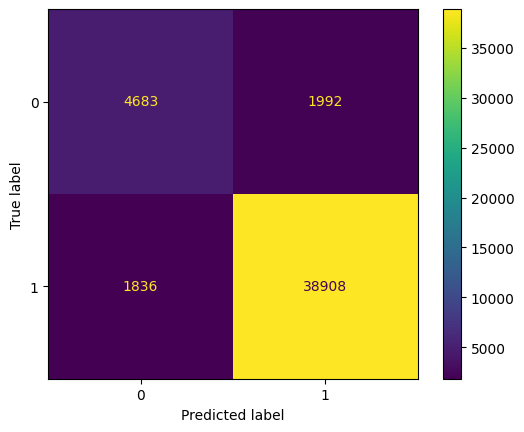


====== threshold=0.30000000000000004 ======
              precision    recall  f1-score   support

           0       0.68      0.75      0.72      6675
           1       0.96      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.85      0.83     47419
weighted avg       0.92      0.92      0.92     47419




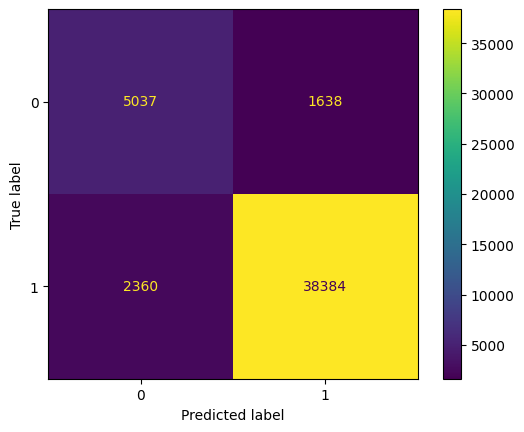


====== threshold=0.35000000000000003 ======
              precision    recall  f1-score   support

           0       0.64      0.80      0.72      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.87      0.83     47419
weighted avg       0.92      0.91      0.91     47419




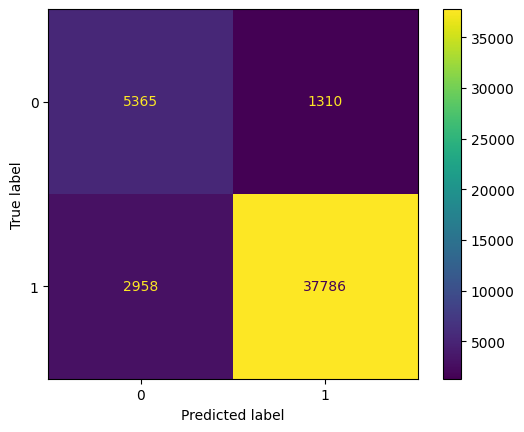


====== threshold=0.4 ======
              precision    recall  f1-score   support

           0       0.58      0.86      0.69      6675
           1       0.97      0.90      0.94     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.88      0.81     47419
weighted avg       0.92      0.89      0.90     47419




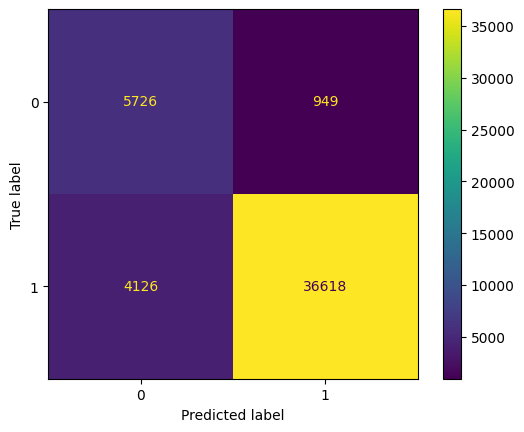


====== threshold=0.45 ======
              precision    recall  f1-score   support

           0       0.55      0.88      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.88      0.80     47419
weighted avg       0.92      0.88      0.89     47419




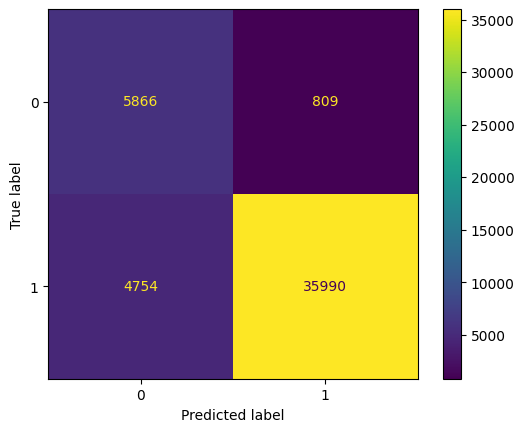


====== threshold=0.5 ======
              precision    recall  f1-score   support

           0       0.53      0.90      0.66      6675
           1       0.98      0.87      0.92     40744

    accuracy                           0.87     47419
   macro avg       0.75      0.88      0.79     47419
weighted avg       0.92      0.87      0.88     47419




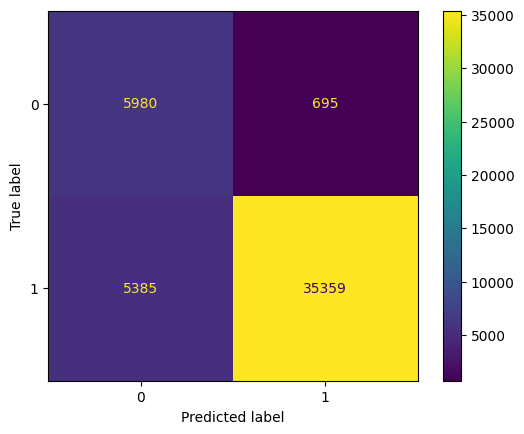


====== threshold=0.55 ======
              precision    recall  f1-score   support

           0       0.50      0.91      0.64      6675
           1       0.98      0.85      0.91     40744

    accuracy                           0.86     47419
   macro avg       0.74      0.88      0.78     47419
weighted avg       0.91      0.86      0.87     47419




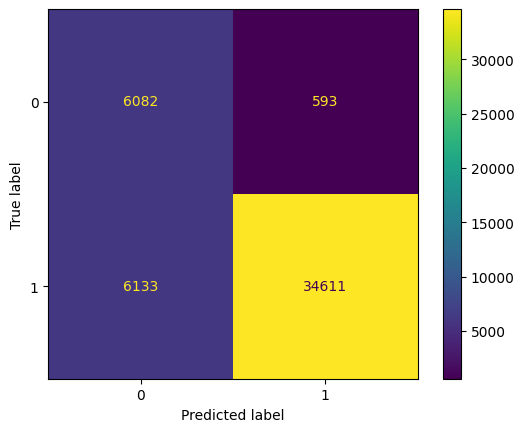


====== threshold=0.6000000000000001 ======
              precision    recall  f1-score   support

           0       0.47      0.93      0.63      6675
           1       0.99      0.83      0.90     40744

    accuracy                           0.84     47419
   macro avg       0.73      0.88      0.76     47419
weighted avg       0.91      0.84      0.86     47419




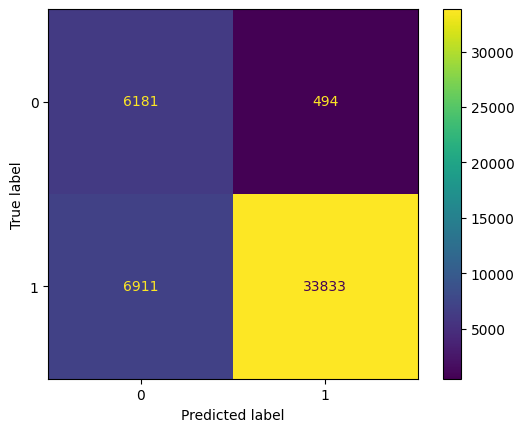


====== threshold=0.65 ======
              precision    recall  f1-score   support

           0       0.45      0.94      0.60      6675
           1       0.99      0.81      0.89     40744

    accuracy                           0.83     47419
   macro avg       0.72      0.87      0.75     47419
weighted avg       0.91      0.83      0.85     47419




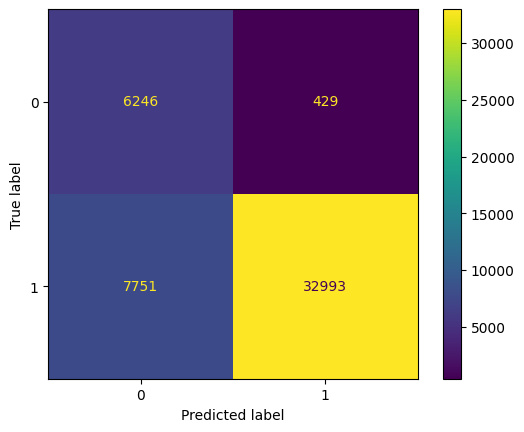


====== threshold=0.7000000000000001 ======
              precision    recall  f1-score   support

           0       0.42      0.95      0.58      6675
           1       0.99      0.79      0.88     40744

    accuracy                           0.81     47419
   macro avg       0.70      0.87      0.73     47419
weighted avg       0.91      0.81      0.83     47419




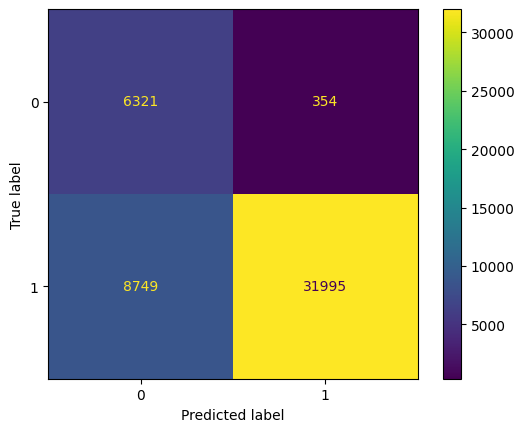


====== threshold=0.75 ======
              precision    recall  f1-score   support

           0       0.39      0.96      0.56      6675
           1       0.99      0.76      0.86     40744

    accuracy                           0.78     47419
   macro avg       0.69      0.86      0.71     47419
weighted avg       0.91      0.78      0.82     47419




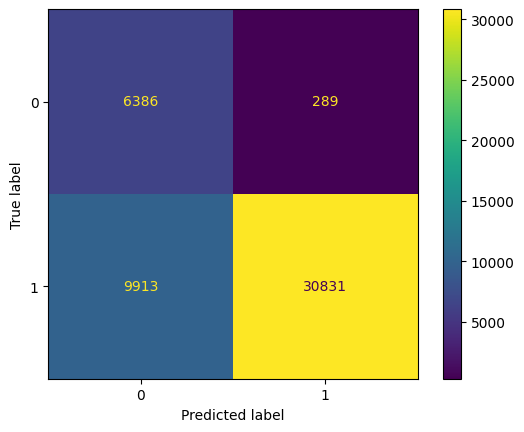


====== threshold=0.8 ======
              precision    recall  f1-score   support

           0       0.36      0.96      0.53      6675
           1       0.99      0.72      0.83     40744

    accuracy                           0.75     47419
   macro avg       0.68      0.84      0.68     47419
weighted avg       0.90      0.75      0.79     47419




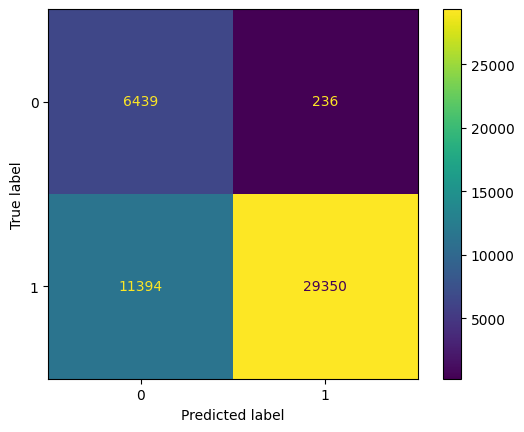


====== threshold=0.8500000000000001 ======
              precision    recall  f1-score   support

           0       0.33      0.97      0.49      6675
           1       0.99      0.67      0.80     40744

    accuracy                           0.71     47419
   macro avg       0.66      0.82      0.64     47419
weighted avg       0.90      0.71      0.76     47419




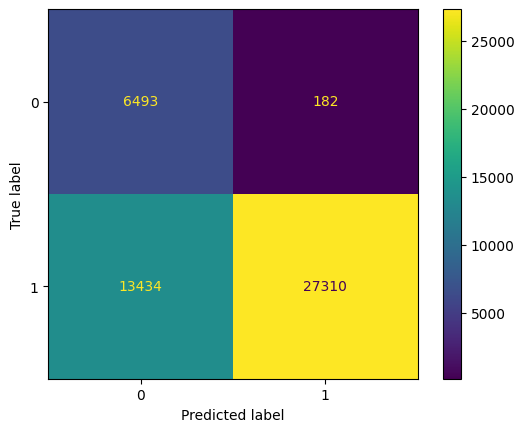


====== threshold=0.9 ======
              precision    recall  f1-score   support

           0       0.28      0.98      0.43      6675
           1       0.99      0.58      0.73     40744

    accuracy                           0.64     47419
   macro avg       0.64      0.78      0.58     47419
weighted avg       0.89      0.64      0.69     47419




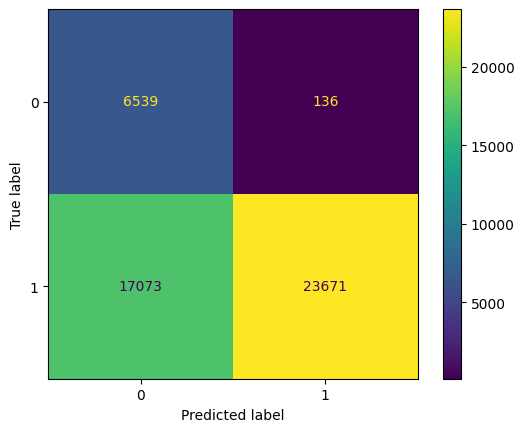


====== threshold=0.9500000000000001 ======
              precision    recall  f1-score   support

           0       0.22      0.99      0.36      6675
           1       0.99      0.42      0.59     40744

    accuracy                           0.50     47419
   macro avg       0.61      0.70      0.47     47419
weighted avg       0.89      0.50      0.56     47419




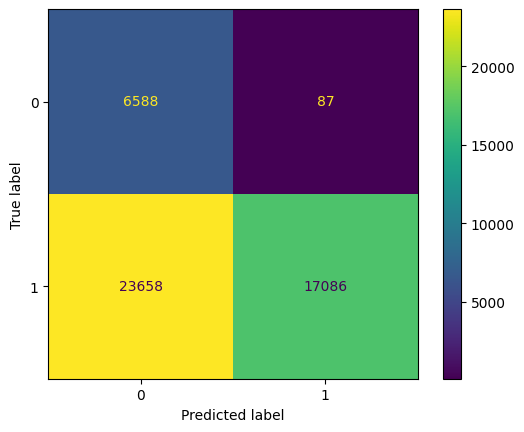

In [ ]:
threshold_selection(cb_pipeline_default_full, X_test['Review'])

#### Baseline

Подгрузим baseline

In [ ]:
baseline_path = "/content/drive/My Drive/classification_of_reviews/model_wb_real.pkl"

baseline = pkl.load(open(baseline_path, "rb"))

In [ ]:
pred = baseline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419



#### CatBaselineClassifier

Так как модели уже обучены, сделаем свой класс для ансамбля, а также подберём веса

In [67]:
class CatBaselineClassifier:
    def __init__(self, weights, cb=cb_pipeline_default_full, lr=baseline):
        self.weights = weights
        self.cb = cb
        self.lr = lr

    def predict(self, texts, threshold=0.5):
        prob1 = self.lr.predict_proba(texts)

        self.cb.named_steps['clf'].set_probability_threshold(threshold)
        prob2 = cb_pipeline_default_full.predict_proba(texts)
        self.cb.named_steps['clf'].set_probability_threshold(0.5)

        weighted_prob = self.weights[0] * prob1 + self.weights[1] * prob2
        return np.argmax(weighted_prob, axis=1)

#### threshold=0.5

====== 0.1:0.9 ======
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.89      0.80     47419
weighted avg       0.92      0.88      0.89     47419




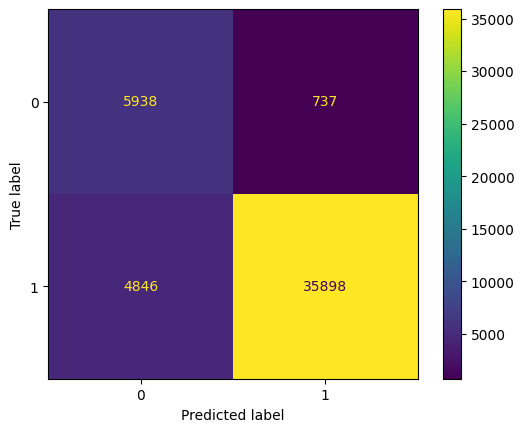


====== 0.14444444444444446:0.8555555555555555 ======
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.89      0.81     47419
weighted avg       0.92      0.89      0.90     47419




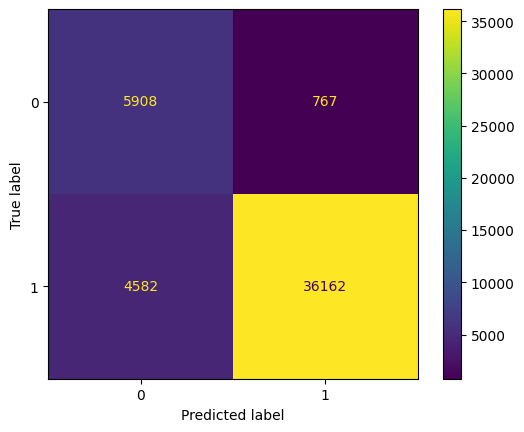


====== 0.18888888888888888:0.8111111111111111 ======
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      6675
           1       0.98      0.90      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.89      0.82     47419
weighted avg       0.92      0.89      0.90     47419




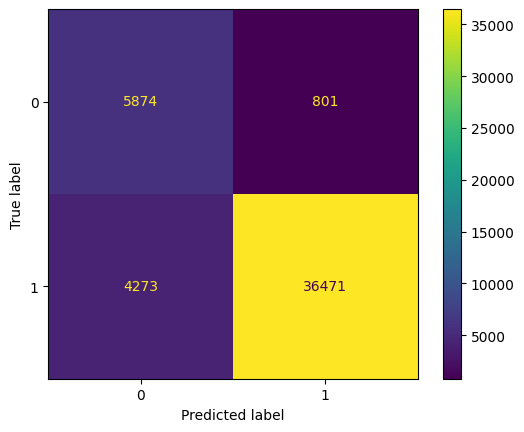


====== 0.23333333333333334:0.7666666666666666 ======
              precision    recall  f1-score   support

           0       0.61      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.90     47419
   macro avg       0.79      0.89      0.83     47419
weighted avg       0.93      0.90      0.91     47419




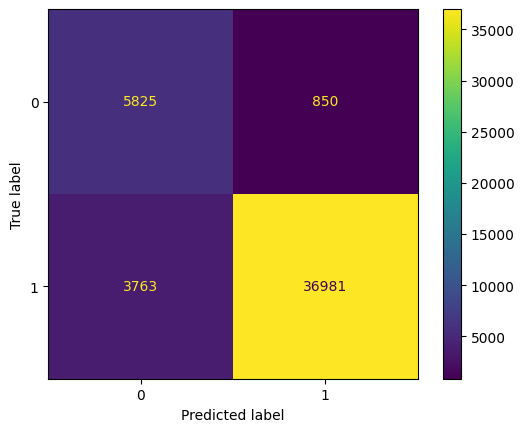


====== 0.2777777777777778:0.7222222222222222 ======
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




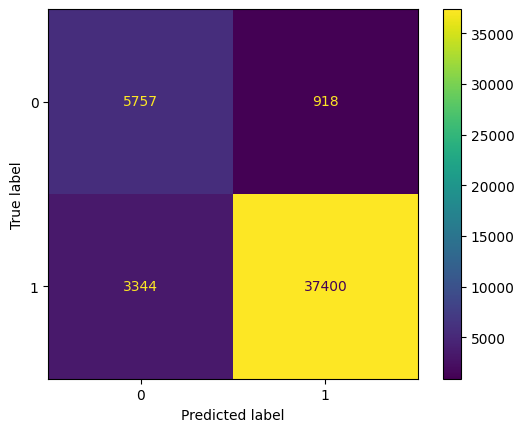


====== 0.32222222222222224:0.6777777777777778 ======
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      6675
           1       0.97      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




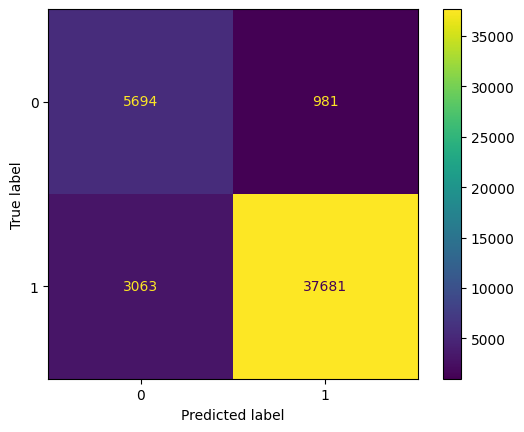


====== 0.3666666666666667:0.6333333333333333 ======
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.89      0.85     47419
weighted avg       0.93      0.92      0.92     47419




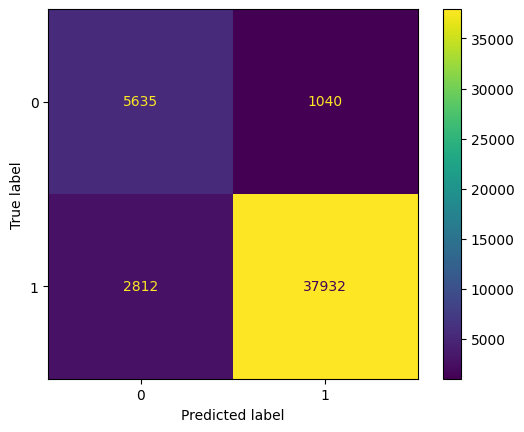


====== 0.4111111111111111:0.5888888888888889 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.89      0.85     47419
weighted avg       0.93      0.92      0.93     47419




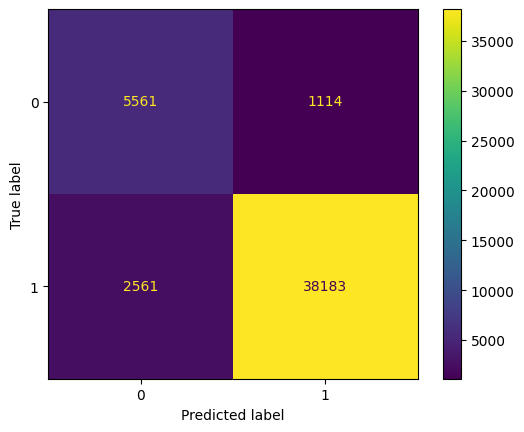


====== 0.4555555555555556:0.5444444444444444 ======
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




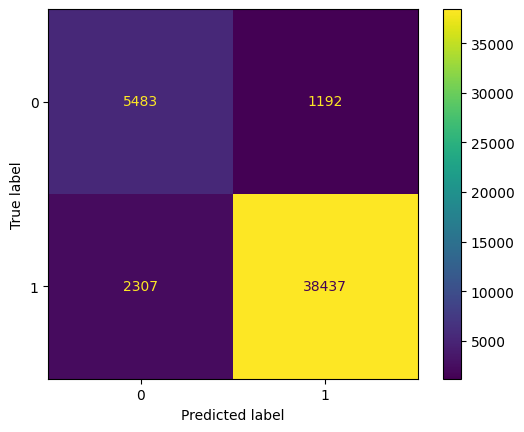


====== 0.5:0.5 ======
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




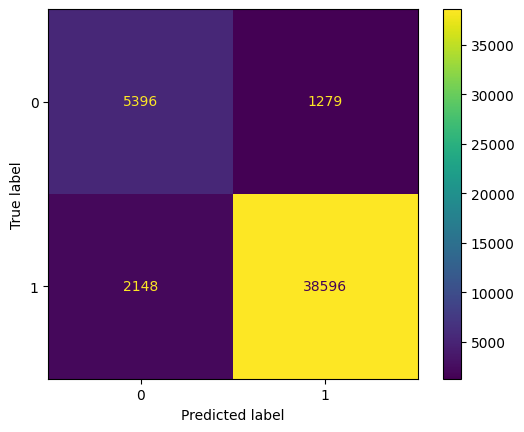


====== 0.5444444444444445:0.4555555555555555 ======
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




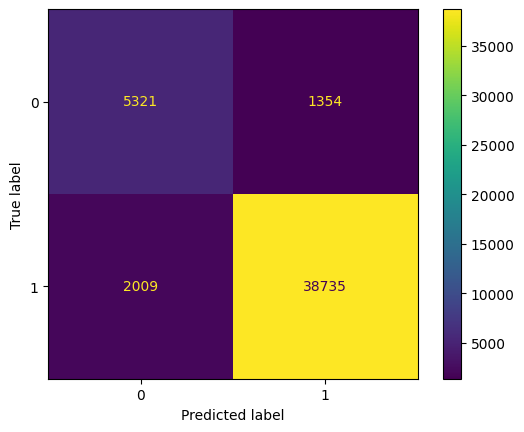


====== 0.5888888888888889:0.4111111111111111 ======
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




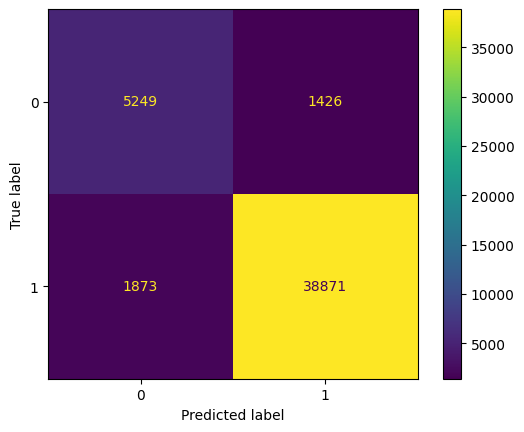


====== 0.6333333333333333:0.3666666666666667 ======
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




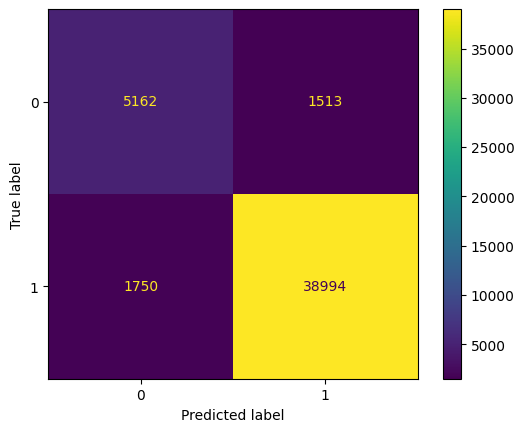


====== 0.6777777777777778:0.3222222222222222 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




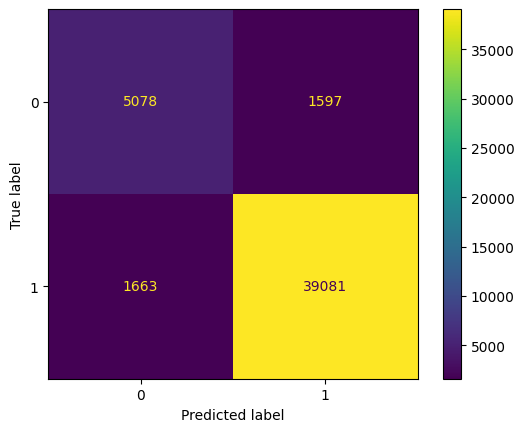


====== 0.7222222222222222:0.2777777777777778 ======
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




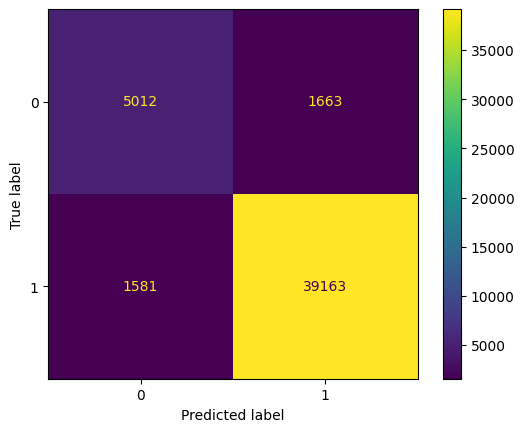


====== 0.7666666666666667:0.23333333333333328 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




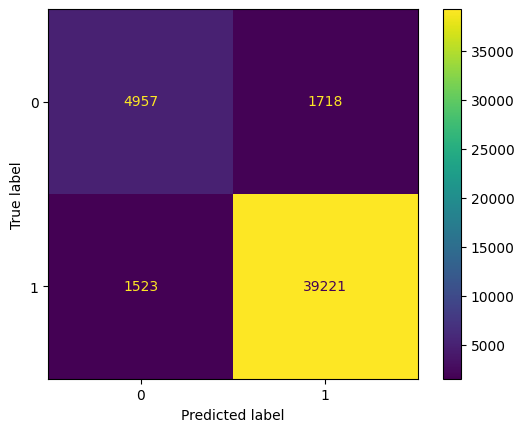


====== 0.8111111111111111:0.18888888888888888 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




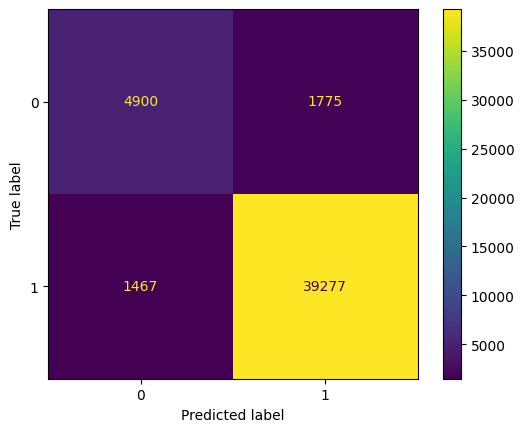


====== 0.8555555555555555:0.1444444444444445 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




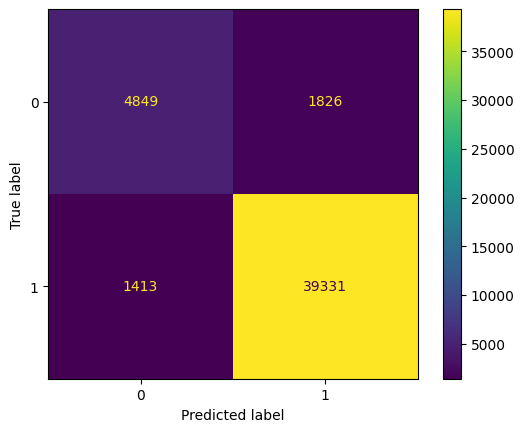


====== 0.9:0.09999999999999998 ======
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




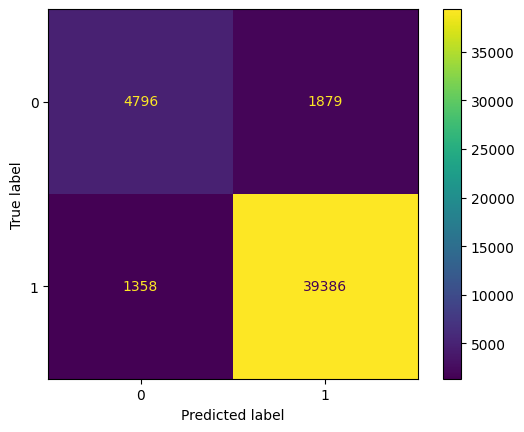

In [ ]:
def threshold_selection_ensemble(threshold=0.5):
    for w in np.linspace(0.1, 0.9, 19):
        weights = [w, 1 - w]
        model = CatBaselineClassifier(weights=weights)

        print(f"====== {w}:{1 - w} ======")

        pred = model.predict(X_test['Review'], threshold)
        print(classification_report(y_test, pred))
        print()

        ConfusionMatrixDisplay.from_predictions(y_test, pred)
        plt.show()
        print()

threshold_selection_ensemble()

#### threshold=0.2

====== 0.1:0.9 ======
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.89      0.80     47419
weighted avg       0.92      0.88      0.89     47419




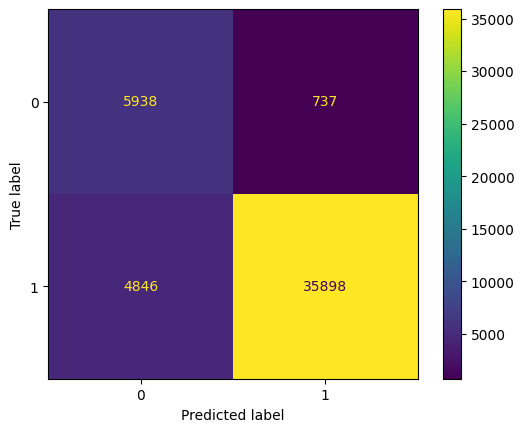


====== 0.14444444444444446:0.8555555555555555 ======
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.89      0.81     47419
weighted avg       0.92      0.89      0.90     47419




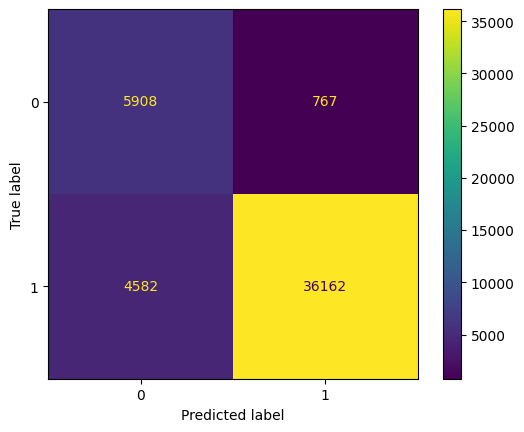


====== 0.18888888888888888:0.8111111111111111 ======
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      6675
           1       0.98      0.90      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.89      0.82     47419
weighted avg       0.92      0.89      0.90     47419




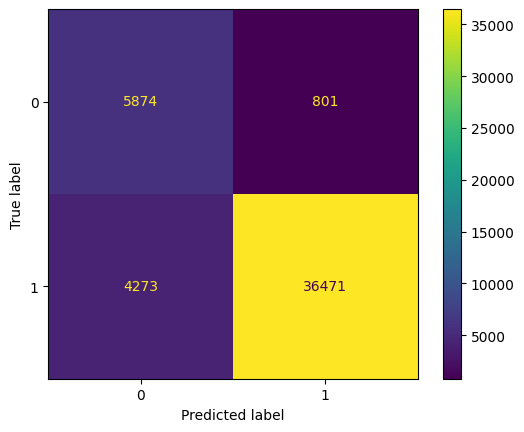


====== 0.23333333333333334:0.7666666666666666 ======
              precision    recall  f1-score   support

           0       0.61      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.90     47419
   macro avg       0.79      0.89      0.83     47419
weighted avg       0.93      0.90      0.91     47419




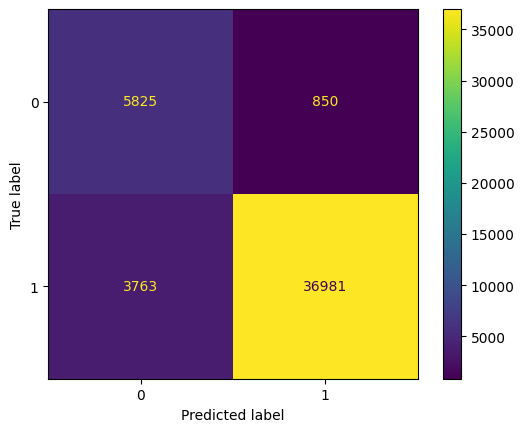


====== 0.2777777777777778:0.7222222222222222 ======
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




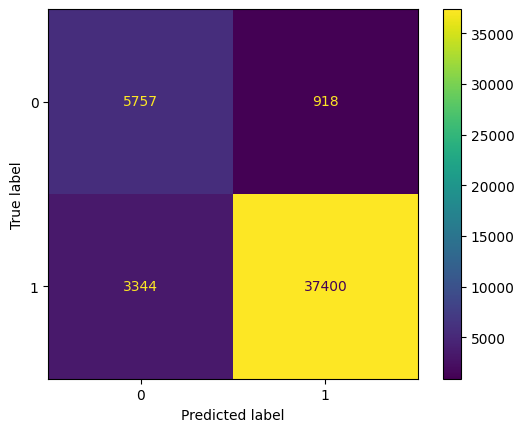


====== 0.32222222222222224:0.6777777777777778 ======
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      6675
           1       0.97      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




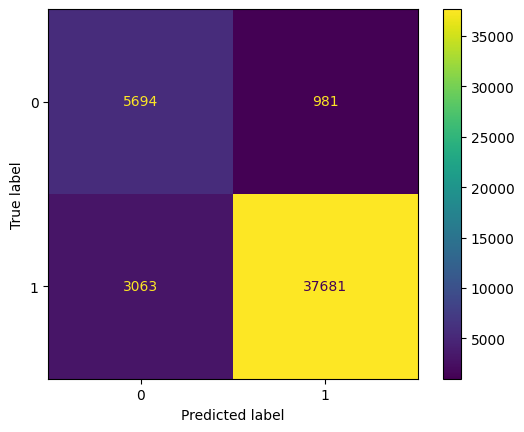


====== 0.3666666666666667:0.6333333333333333 ======
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.89      0.85     47419
weighted avg       0.93      0.92      0.92     47419




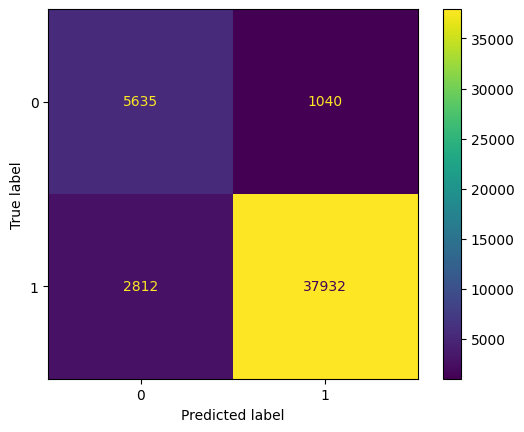


====== 0.4111111111111111:0.5888888888888889 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.89      0.85     47419
weighted avg       0.93      0.92      0.93     47419




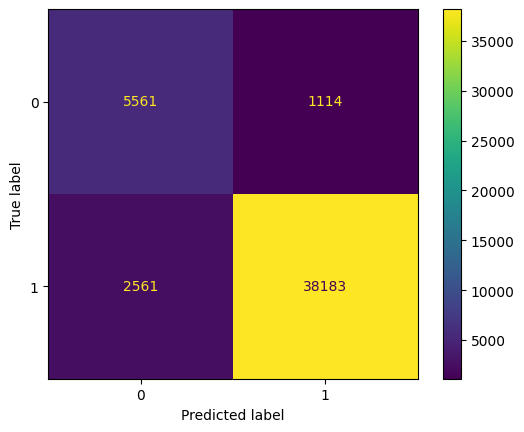


====== 0.4555555555555556:0.5444444444444444 ======
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




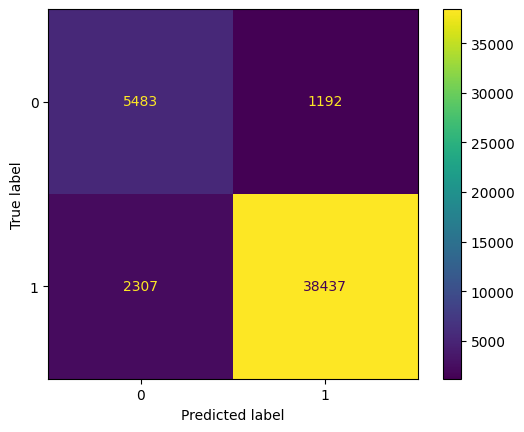


====== 0.5:0.5 ======
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




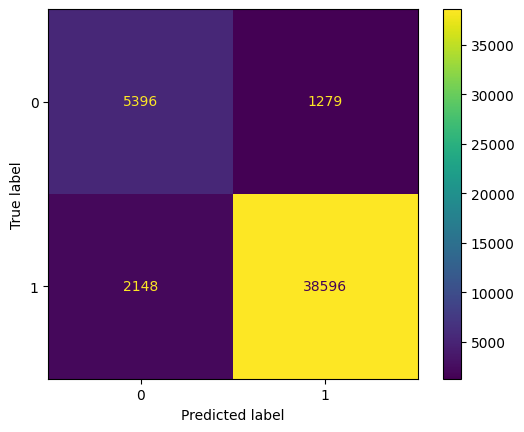


====== 0.5444444444444445:0.4555555555555555 ======
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




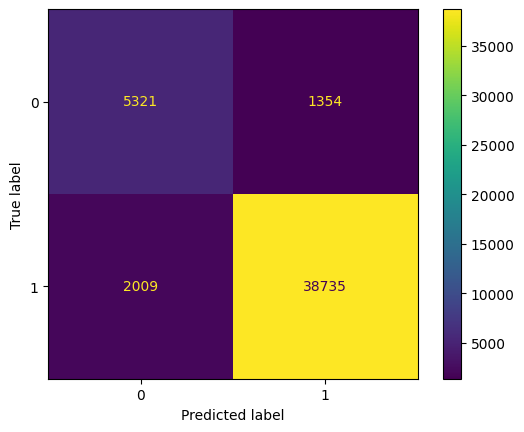


====== 0.5888888888888889:0.4111111111111111 ======
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




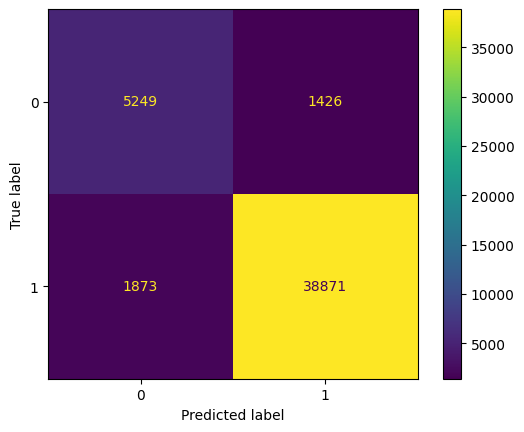


====== 0.6333333333333333:0.3666666666666667 ======
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




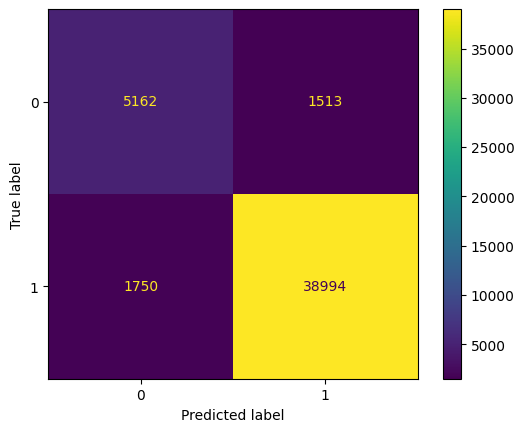


====== 0.6777777777777778:0.3222222222222222 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




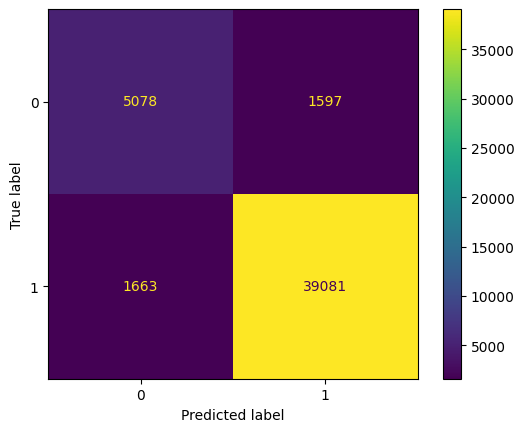


====== 0.7222222222222222:0.2777777777777778 ======
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




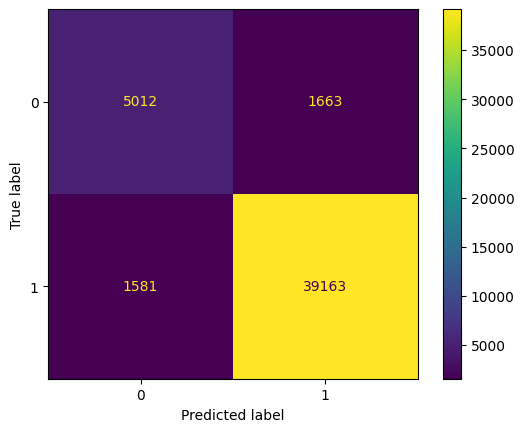


====== 0.7666666666666667:0.23333333333333328 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




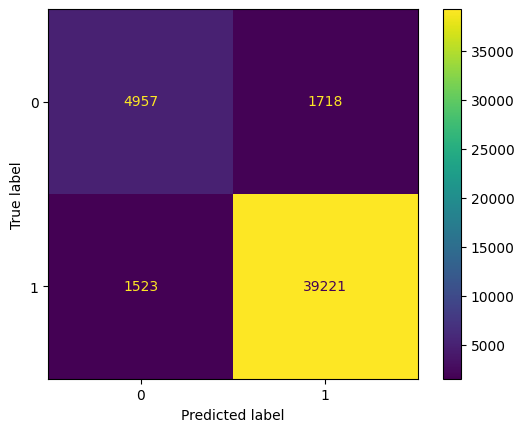


====== 0.8111111111111111:0.18888888888888888 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




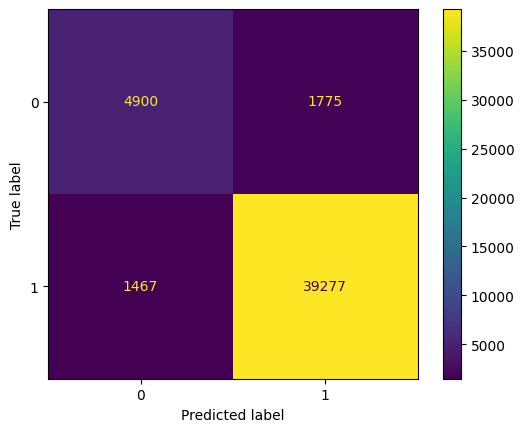


====== 0.8555555555555555:0.1444444444444445 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




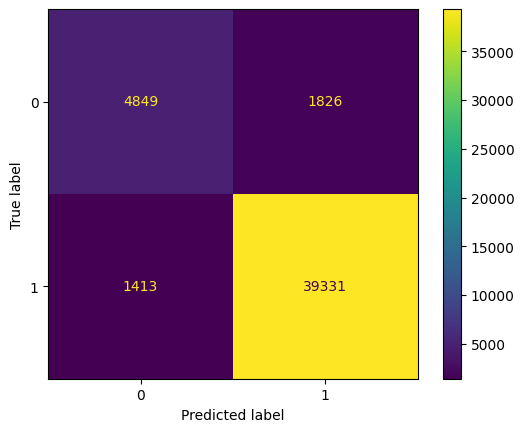


====== 0.9:0.09999999999999998 ======
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




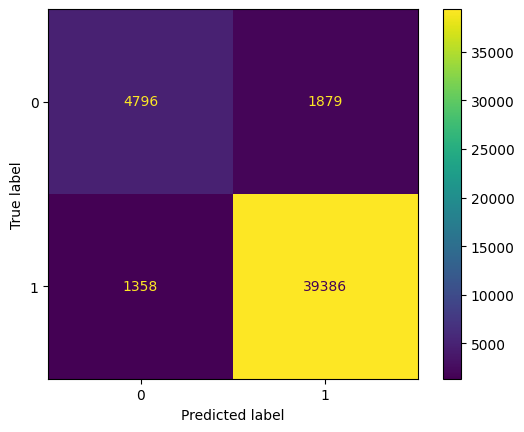

In [ ]:
threshold_selection_ensemble(0.2)

#### threshold=0.25

====== 0.1:0.9 ======
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.89      0.80     47419
weighted avg       0.92      0.88      0.89     47419




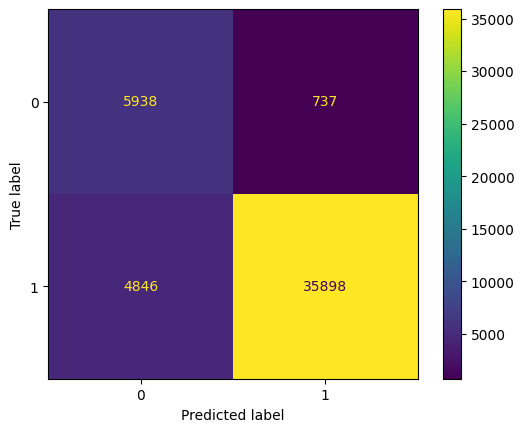


====== 0.14444444444444446:0.8555555555555555 ======
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.89      0.81     47419
weighted avg       0.92      0.89      0.90     47419




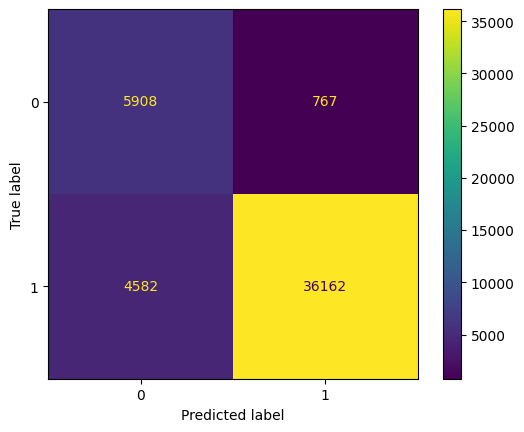


====== 0.18888888888888888:0.8111111111111111 ======
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      6675
           1       0.98      0.90      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.89      0.82     47419
weighted avg       0.92      0.89      0.90     47419




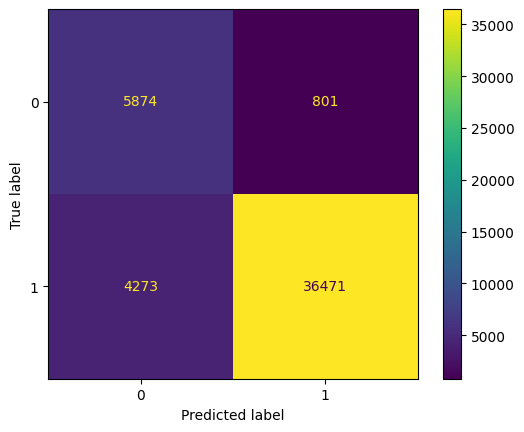


====== 0.23333333333333334:0.7666666666666666 ======
              precision    recall  f1-score   support

           0       0.61      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.90     47419
   macro avg       0.79      0.89      0.83     47419
weighted avg       0.93      0.90      0.91     47419




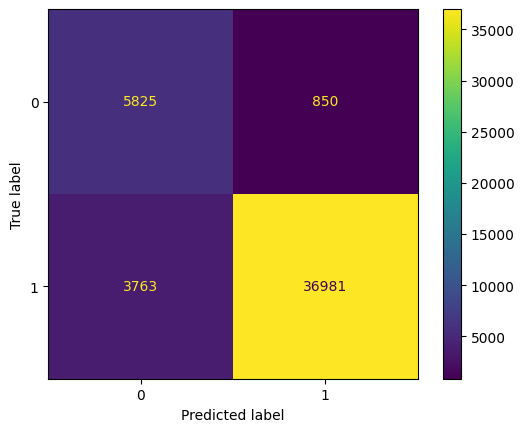


====== 0.2777777777777778:0.7222222222222222 ======
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




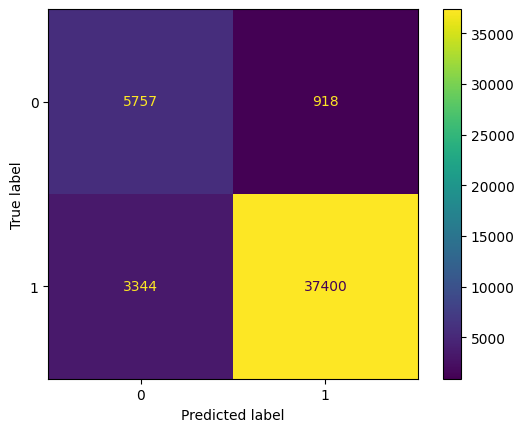


====== 0.32222222222222224:0.6777777777777778 ======
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      6675
           1       0.97      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




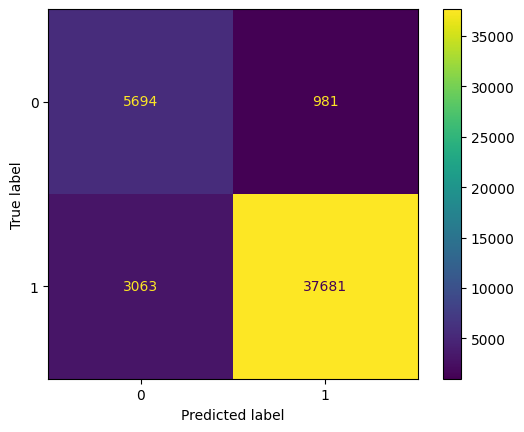


====== 0.3666666666666667:0.6333333333333333 ======
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.89      0.85     47419
weighted avg       0.93      0.92      0.92     47419




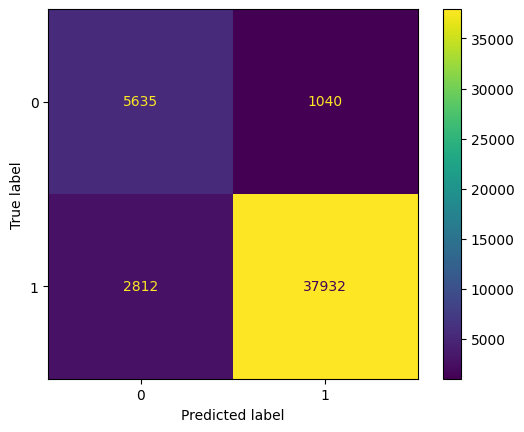


====== 0.4111111111111111:0.5888888888888889 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.89      0.85     47419
weighted avg       0.93      0.92      0.93     47419




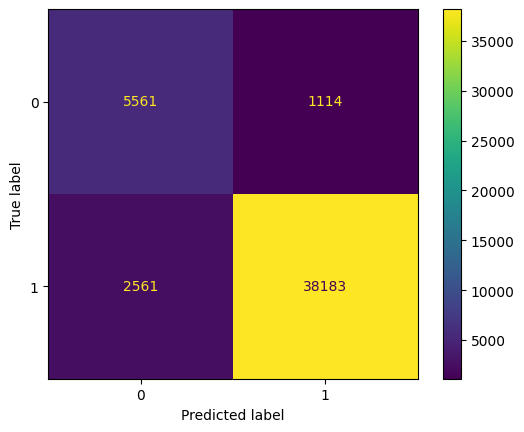


====== 0.4555555555555556:0.5444444444444444 ======
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




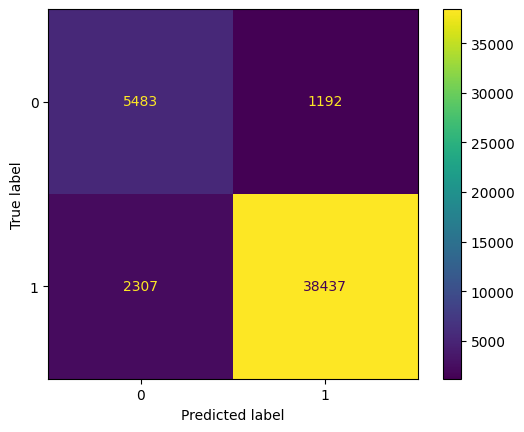


====== 0.5:0.5 ======
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




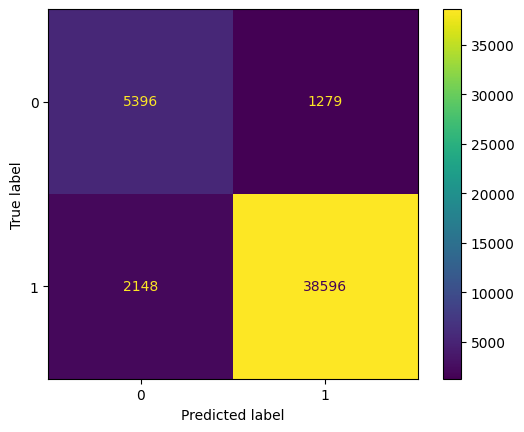


====== 0.5444444444444445:0.4555555555555555 ======
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




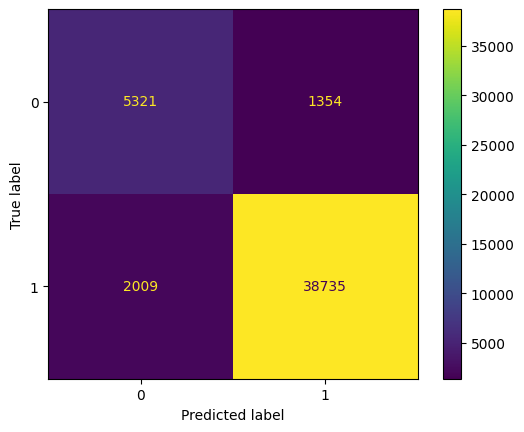


====== 0.5888888888888889:0.4111111111111111 ======
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




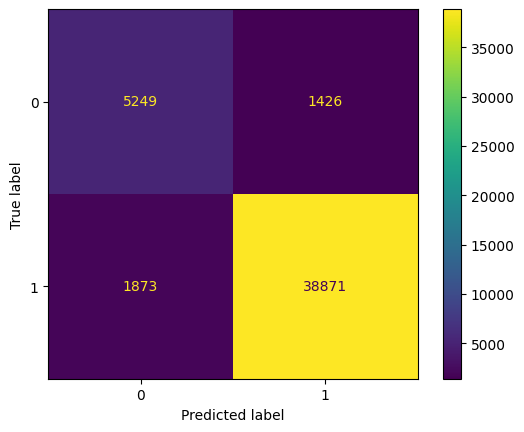


====== 0.6333333333333333:0.3666666666666667 ======
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




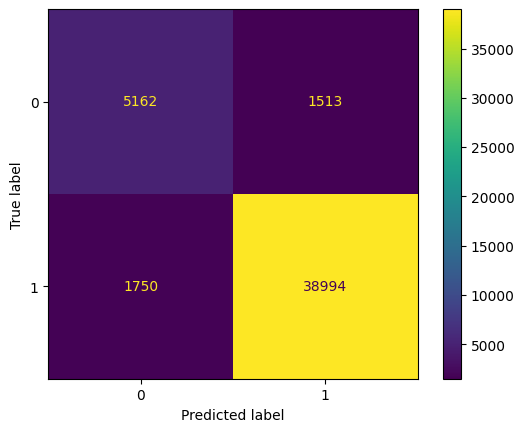


====== 0.6777777777777778:0.3222222222222222 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




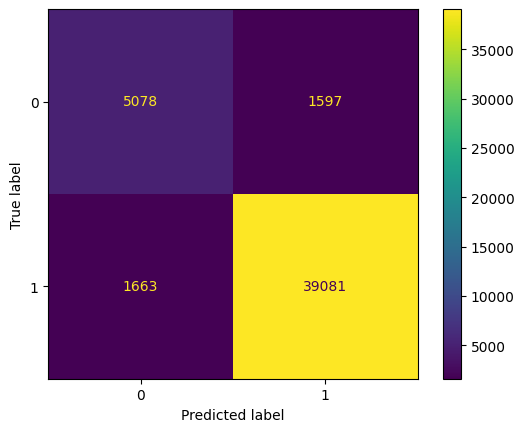


====== 0.7222222222222222:0.2777777777777778 ======
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




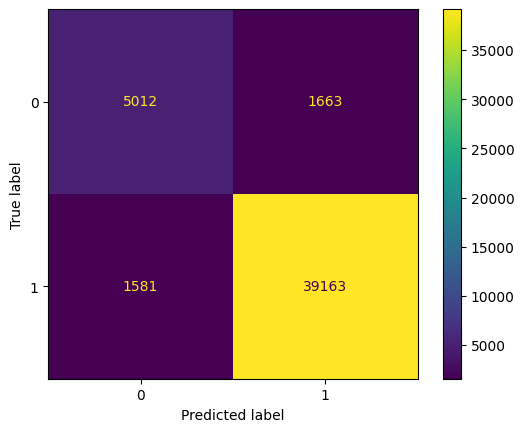


====== 0.7666666666666667:0.23333333333333328 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




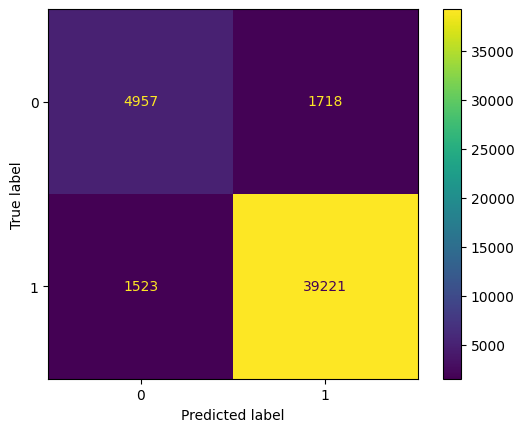


====== 0.8111111111111111:0.18888888888888888 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




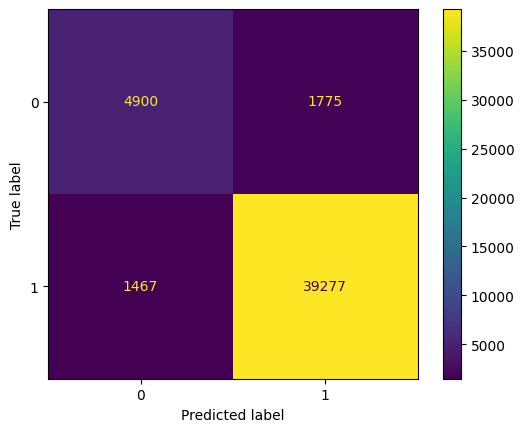


====== 0.8555555555555555:0.1444444444444445 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




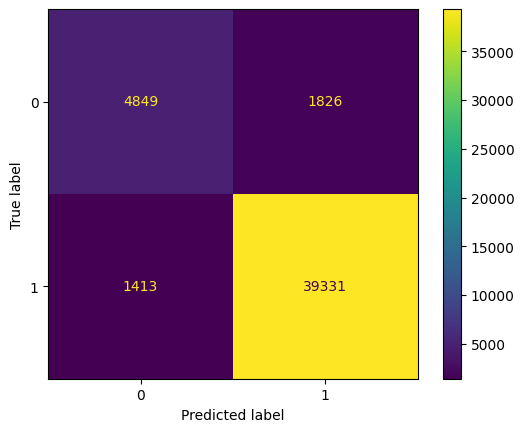


====== 0.9:0.09999999999999998 ======
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




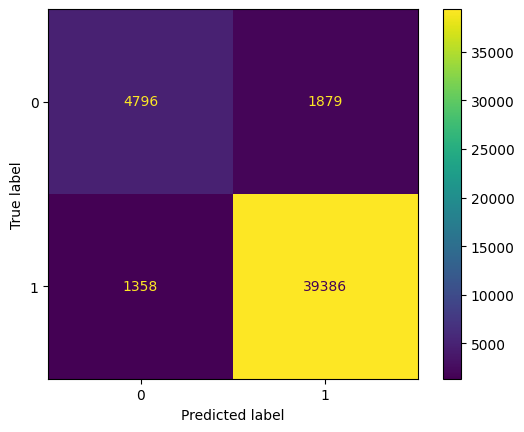

In [ ]:
threshold_selection_ensemble(0.25)

#### threshold=0.3

====== 0.1:0.9 ======
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.89      0.80     47419
weighted avg       0.92      0.88      0.89     47419




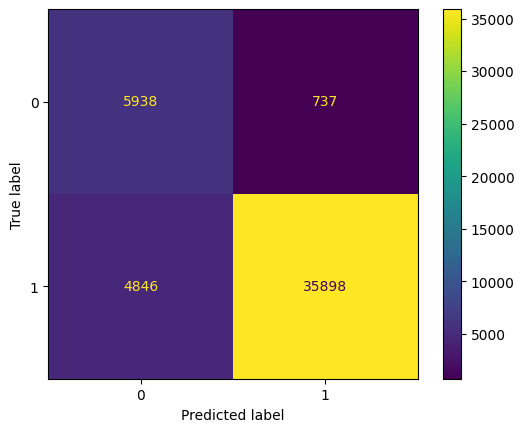


====== 0.14444444444444446:0.8555555555555555 ======
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.89      0.81     47419
weighted avg       0.92      0.89      0.90     47419




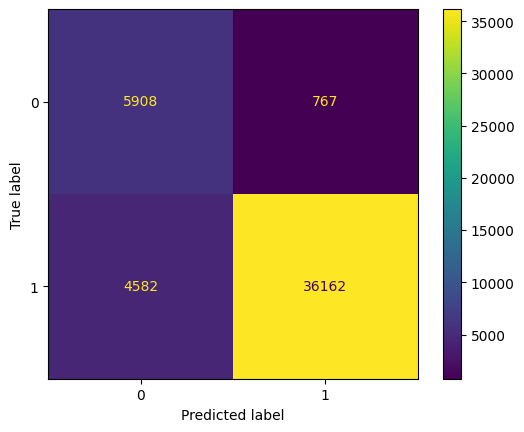


====== 0.18888888888888888:0.8111111111111111 ======
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      6675
           1       0.98      0.90      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.89      0.82     47419
weighted avg       0.92      0.89      0.90     47419




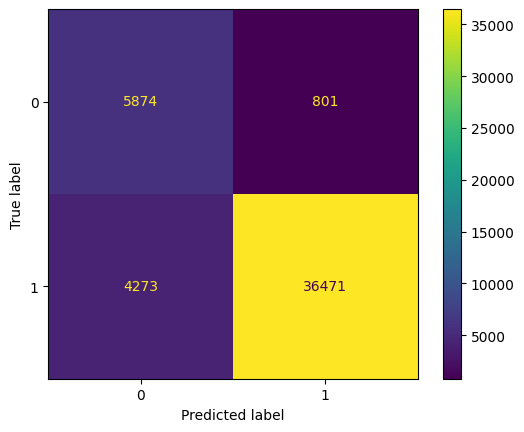


====== 0.23333333333333334:0.7666666666666666 ======
              precision    recall  f1-score   support

           0       0.61      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.90     47419
   macro avg       0.79      0.89      0.83     47419
weighted avg       0.93      0.90      0.91     47419




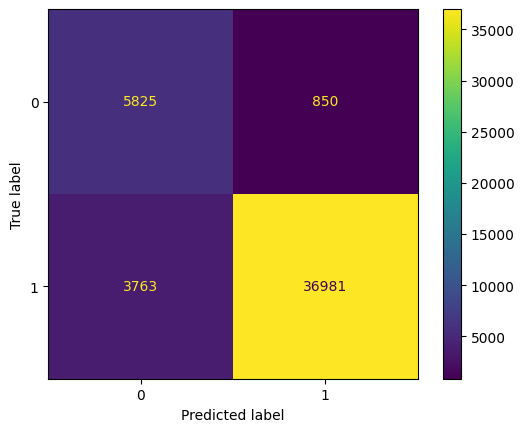


====== 0.2777777777777778:0.7222222222222222 ======
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




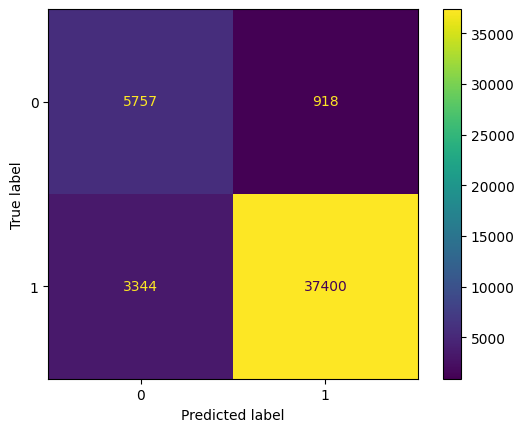


====== 0.32222222222222224:0.6777777777777778 ======
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      6675
           1       0.97      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




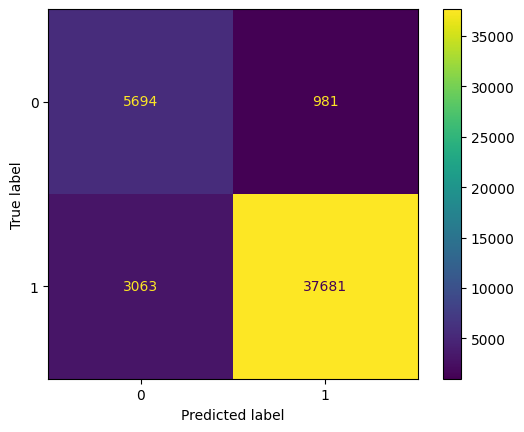


====== 0.3666666666666667:0.6333333333333333 ======
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.89      0.85     47419
weighted avg       0.93      0.92      0.92     47419




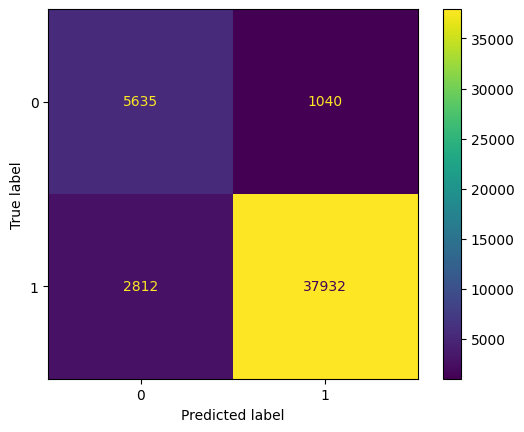


====== 0.4111111111111111:0.5888888888888889 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.89      0.85     47419
weighted avg       0.93      0.92      0.93     47419




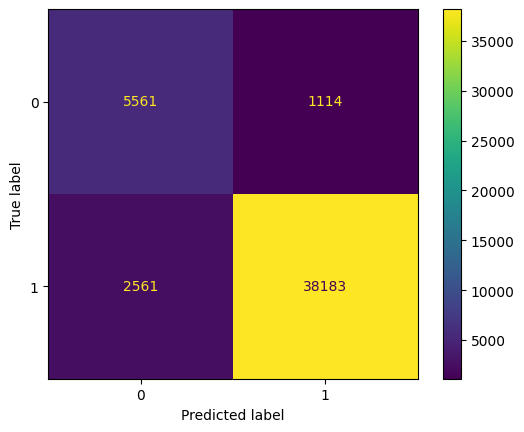


====== 0.4555555555555556:0.5444444444444444 ======
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




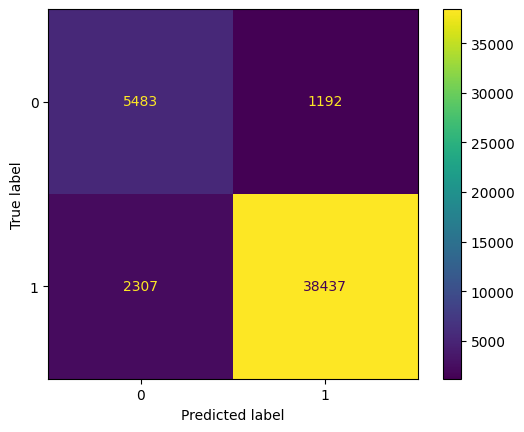


====== 0.5:0.5 ======
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




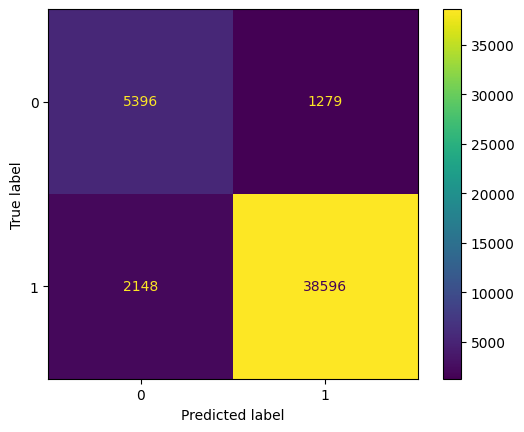


====== 0.5444444444444445:0.4555555555555555 ======
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




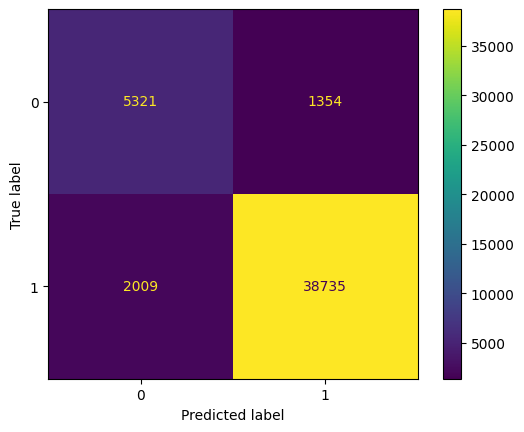


====== 0.5888888888888889:0.4111111111111111 ======
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




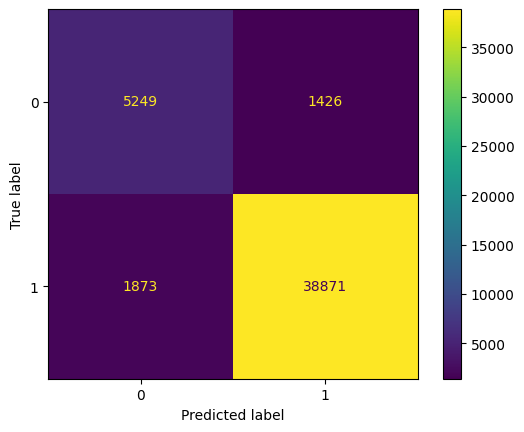


====== 0.6333333333333333:0.3666666666666667 ======
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




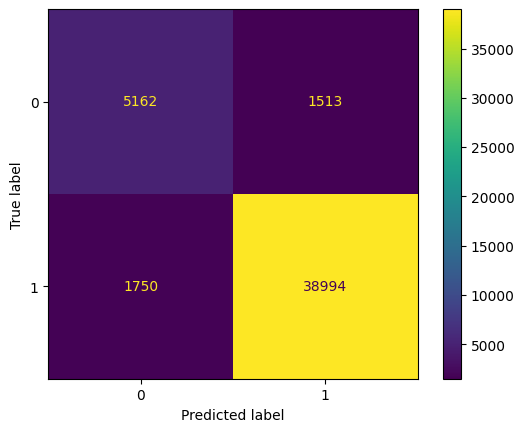


====== 0.6777777777777778:0.3222222222222222 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




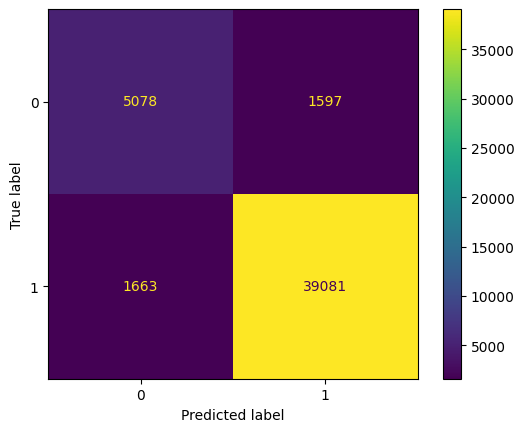


====== 0.7222222222222222:0.2777777777777778 ======
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




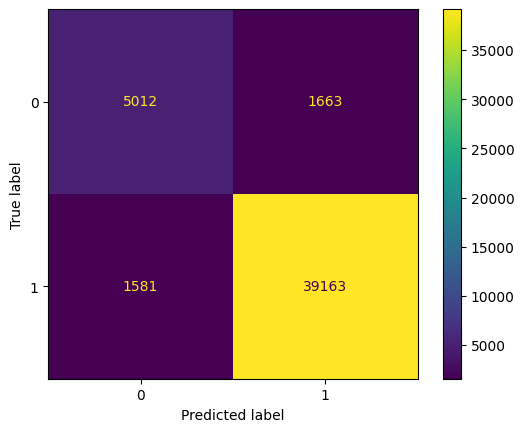


====== 0.7666666666666667:0.23333333333333328 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




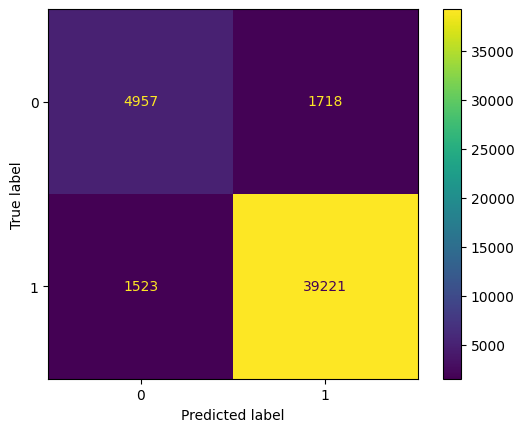


====== 0.8111111111111111:0.18888888888888888 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




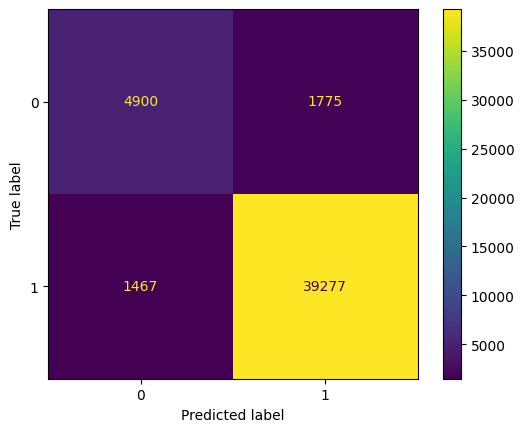


====== 0.8555555555555555:0.1444444444444445 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




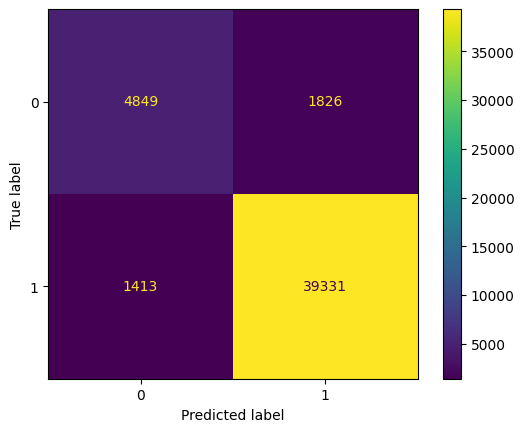


====== 0.9:0.09999999999999998 ======
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




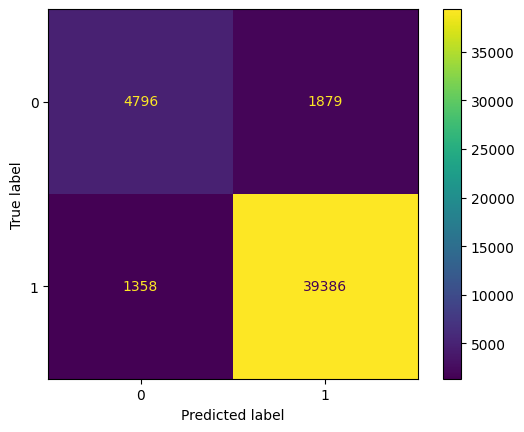

In [ ]:
threshold_selection_ensemble(0.3)

#### threshold=0.35

====== 0.1:0.9 ======
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      6675
           1       0.98      0.88      0.93     40744

    accuracy                           0.88     47419
   macro avg       0.77      0.89      0.80     47419
weighted avg       0.92      0.88      0.89     47419




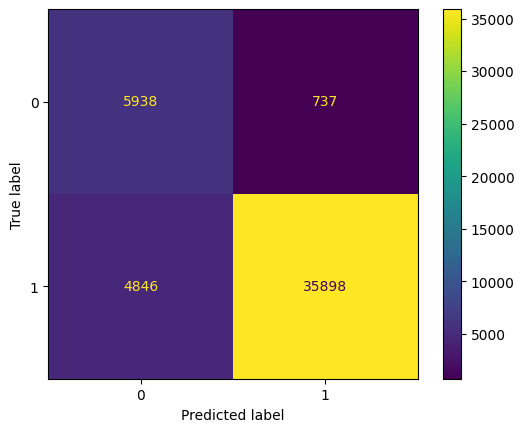


====== 0.14444444444444446:0.8555555555555555 ======
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.89      0.81     47419
weighted avg       0.92      0.89      0.90     47419




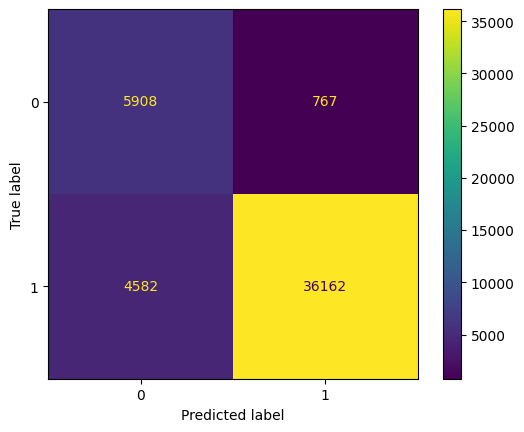


====== 0.18888888888888888:0.8111111111111111 ======
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      6675
           1       0.98      0.90      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.78      0.89      0.82     47419
weighted avg       0.92      0.89      0.90     47419




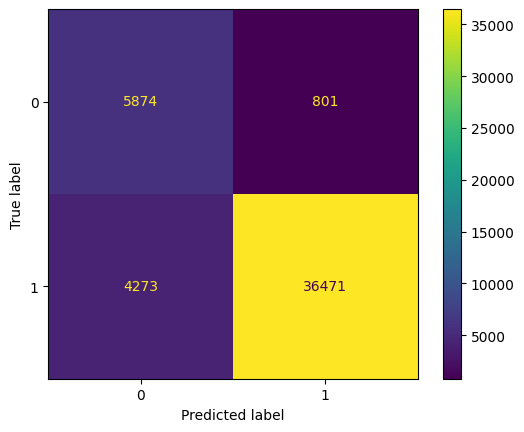


====== 0.23333333333333334:0.7666666666666666 ======
              precision    recall  f1-score   support

           0       0.61      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.90     47419
   macro avg       0.79      0.89      0.83     47419
weighted avg       0.93      0.90      0.91     47419




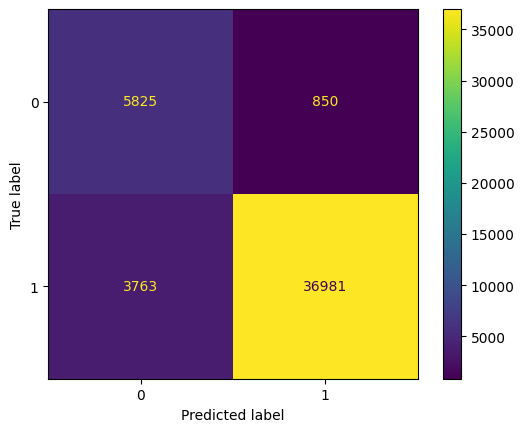


====== 0.2777777777777778:0.7222222222222222 ======
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




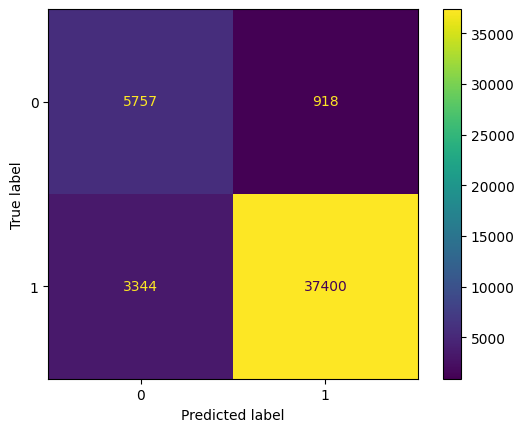


====== 0.32222222222222224:0.6777777777777778 ======
              precision    recall  f1-score   support

           0       0.65      0.85      0.74      6675
           1       0.97      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




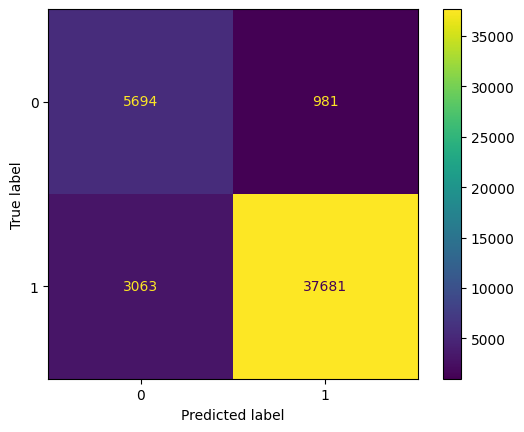


====== 0.3666666666666667:0.6333333333333333 ======
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.89      0.85     47419
weighted avg       0.93      0.92      0.92     47419




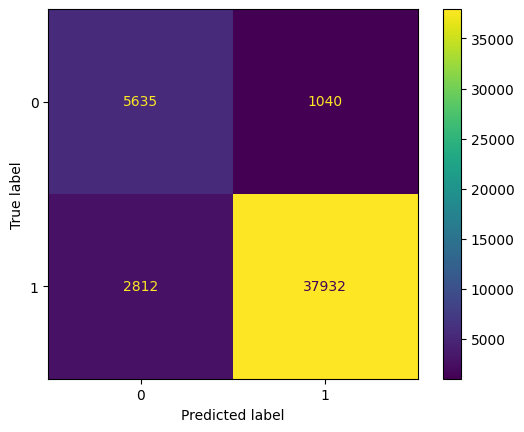


====== 0.4111111111111111:0.5888888888888889 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.89      0.85     47419
weighted avg       0.93      0.92      0.93     47419




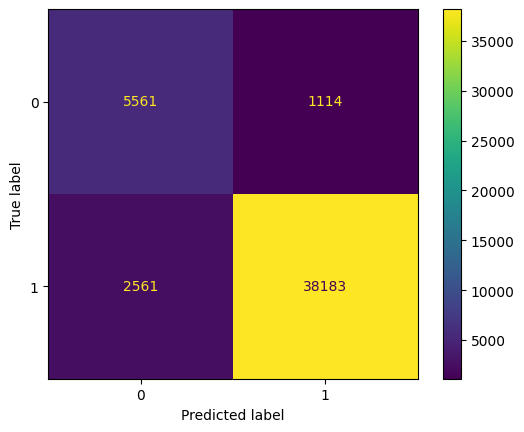


====== 0.4555555555555556:0.5444444444444444 ======
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




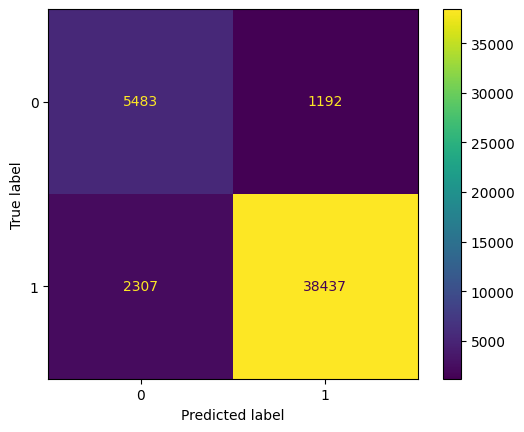


====== 0.5:0.5 ======
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.88      0.86     47419
weighted avg       0.93      0.93      0.93     47419




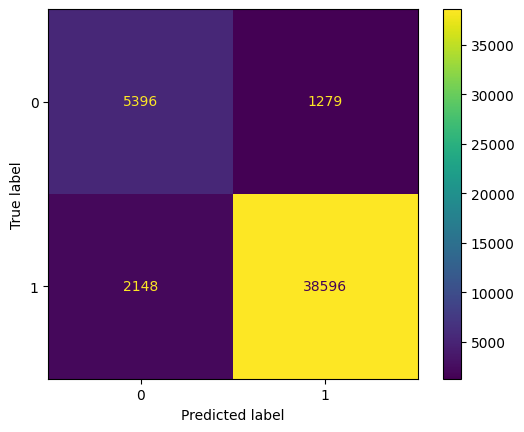


====== 0.5444444444444445:0.4555555555555555 ======
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




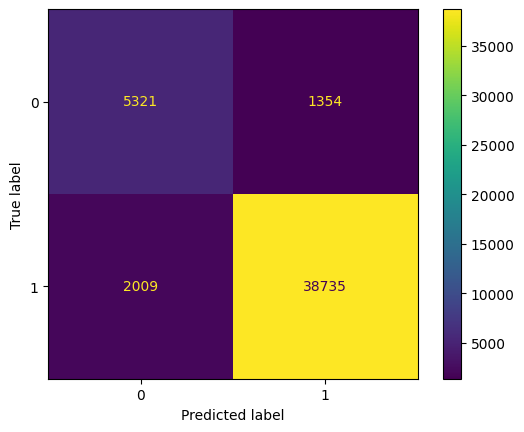


====== 0.5888888888888889:0.4111111111111111 ======
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




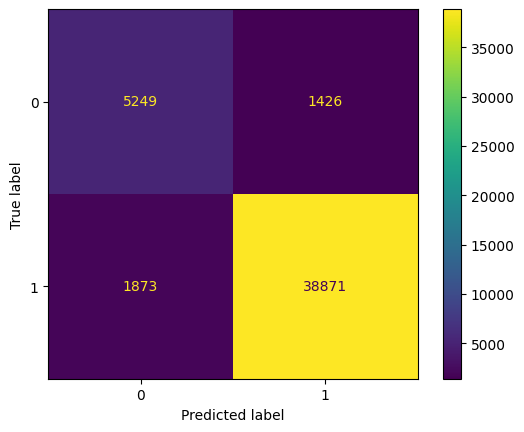


====== 0.6333333333333333:0.3666666666666667 ======
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




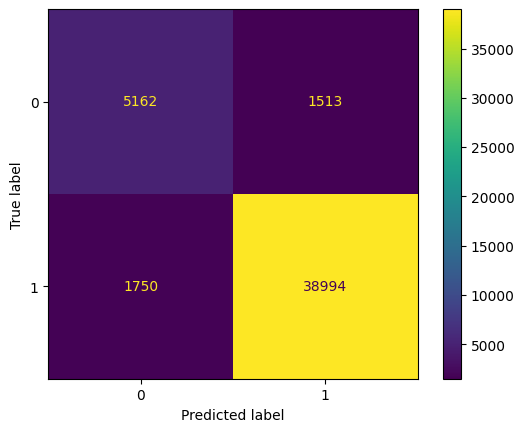


====== 0.6777777777777778:0.3222222222222222 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




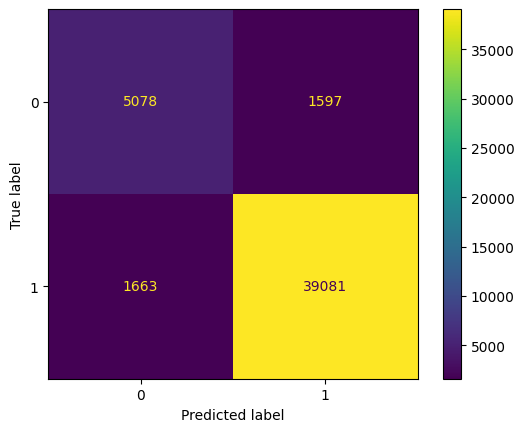


====== 0.7222222222222222:0.2777777777777778 ======
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




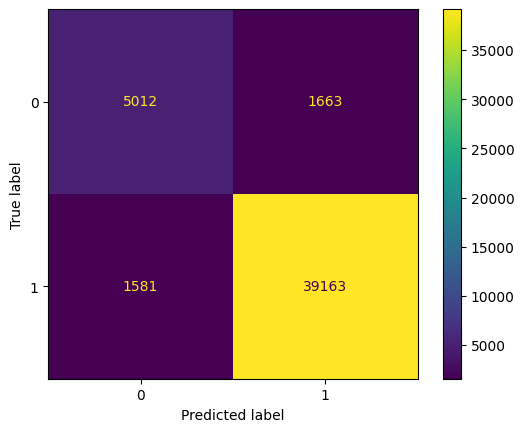


====== 0.7666666666666667:0.23333333333333328 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




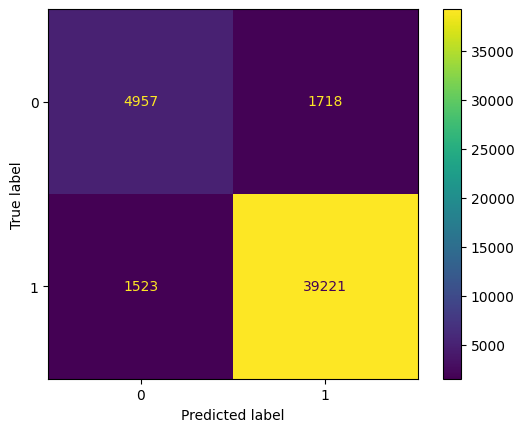


====== 0.8111111111111111:0.18888888888888888 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




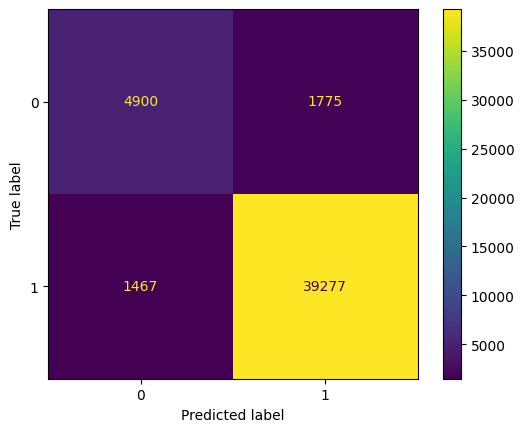


====== 0.8555555555555555:0.1444444444444445 ======
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6675
           1       0.96      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.86     47419
weighted avg       0.93      0.93      0.93     47419




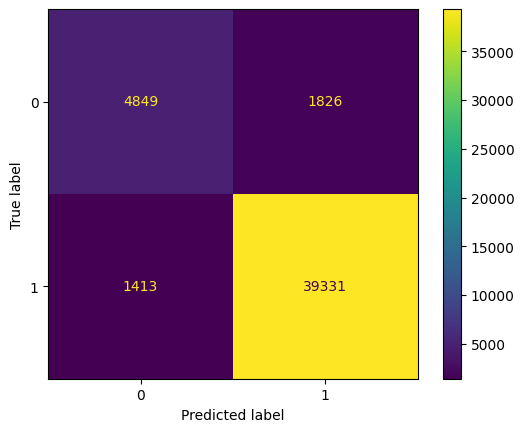


====== 0.9:0.09999999999999998 ======
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




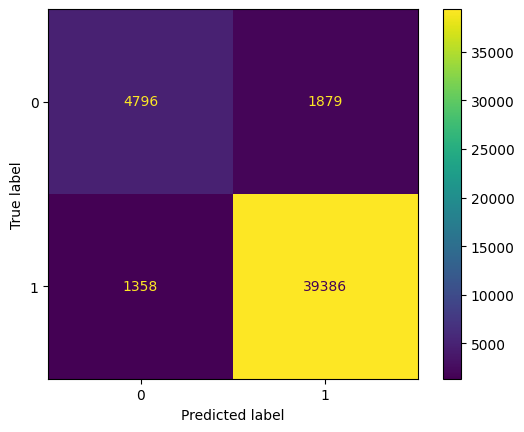

In [ ]:
threshold_selection_ensemble(0.35)

### Catboost c доп. признаком пробы baseline'a

In [50]:
data_with_lr_prob = data_clean_russian.copy()
data_with_lr_prob['Logreg prob'] = baseline.predict_proba(data_with_lr_prob['Review'])[:, 0]

In [51]:
data_with_lr_prob

Good's name  \
0       Мочалка для душа Grizzly XXL для тела черная   
1       Мочалка для душа Grizzly XXL для тела черная   
2       Мочалка для душа Grizzly XXL для тела черная   
3       Мочалка для душа Grizzly XXL для тела черная   
4       Мочалка для душа Grizzly XXL для тела черная   
...                                              ...   
189668     Звонок дверной беспроводной на батарейках   
189669     Звонок дверной беспроводной на батарейках   
189670     Звонок дверной беспроводной на батарейках   
189671     Звонок дверной беспроводной на батарейках   
189672     Звонок дверной беспроводной на батарейках   

                                              Description  \
0       Готовы к незабываемым впечатлениям в душе? «Gr...   
1       Готовы к незабываемым впечатлениям в душе? «Gr...   
2       Готовы к незабываемым впечатлениям в душе? «Gr...   
3       Готовы к незабываемым впечатлениям в душе? «Gr...   
4       Готовы к незабываемым впечатлениям в душе? «Gr...   
...                                                   ...   
189668  Звонок дверной беспроводной влагозащищенный ул...   
189669  Звонок дверной беспроводной влагозащищенный ул...   
189670  Звонок дверной беспроводной влагозащищенный ул...   
189671  Звонок дверной беспроводной влагозащищенный ул...   
189672  Звонок дверной беспроводной влагозащищенный ул...   

                                                   Review  Rating  Sentiment  \
0                                              хорош моет      10          1   
1       при перв использован замет что мочалк осыпа вс...       2          0   
2                                               супер все      10          1   
3       пошит на перв взгляд не плох мыл не особ хорош...      10          1   
4                                              слишк мягк       2          0   
...                                                   ...     ...        ...   
189668  прекрасн звонок у нас получ дальност действ ме...      10          1   
189669                        все супер звонок прост вауу      10          1   
189670  классн звонок скольк у нас из былоэтот сам луч...      10          1   
189671  звен звонк нет очен хорош звоночек мног мелод ...      10          1   
189672            куп в частн дом все работа хорош звонок      10          1   

        Russian chars  Logreg prob  
0                  10     0.000438  
1                  99     0.946007  
2                   7     0.000888  
3                 120     0.296196  
4                  13     0.314330  
...               ...          ...  
189668            132     0.021140  
189669             24     0.002831  
189670             81     0.002737  
189671             70     0.003310  
189672             41     0.009944  

[189673 rows x 7 columns]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(ngram_range=(1, 2)), 'Review'),
        ('num', StandardScaler(), ['Logreg prob'])
    ],
    remainder='drop'
)

In [ ]:
cb_with_probs = Pipeline([
    ('prep', preprocessor),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose=50))
])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data_with_lr_prob[['Review', 'Logreg prob']],
                                                    data_with_lr_prob['Sentiment'],
                                                    stratify=data_with_lr_prob['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [55]:
cb_with_probs.fit(X_train, y_train)

Learning rate set to 0.085564
0:	learn: 0.5520087	total: 5.78s	remaining: 1h 36m 12s
50:	learn: 0.0716468	total: 3m 1s	remaining: 56m 9s
100:	learn: 0.0685435	total: 5m 50s	remaining: 52m 1s
150:	learn: 0.0662896	total: 8m 39s	remaining: 48m 39s
200:	learn: 0.0629218	total: 11m 29s	remaining: 45m 40s
250:	learn: 0.0602037	total: 14m 20s	remaining: 42m 47s
300:	learn: 0.0575885	total: 17m 13s	remaining: 39m 59s
350:	learn: 0.0559452	total: 20m 6s	remaining: 37m 10s
400:	learn: 0.0543679	total: 22m 58s	remaining: 34m 18s
450:	learn: 0.0528184	total: 25m 52s	remaining: 31m 30s
500:	learn: 0.0517393	total: 28m 45s	remaining: 28m 38s
550:	learn: 0.0506494	total: 31m 40s	remaining: 25m 48s
600:	learn: 0.0494267	total: 34m 34s	remaining: 22m 57s
650:	learn: 0.0484928	total: 37m 28s	remaining: 20m 5s
700:	learn: 0.0476676	total: 40m 22s	remaining: 17m 13s
750:	learn: 0.0468590	total: 43m 17s	remaining: 14m 21s
800:	learn: 0.0462013	total: 46m 9s	remaining: 11m 28s
850:	learn: 0.0455299	total: 

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'Review'),
                                                 ('num', StandardScaler(),
                                                  ['Logreg prob'])])),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7d40b8bfc0d0>)])

Original classification threshold:
0.5
====== threshold=0.05 ======
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.83      0.85     47419
weighted avg       0.93      0.93      0.93     47419




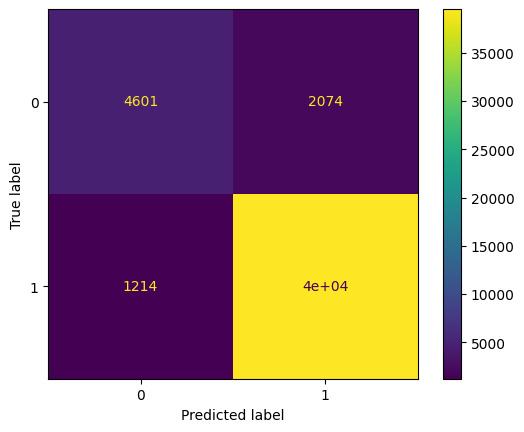


====== threshold=0.1 ======
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419




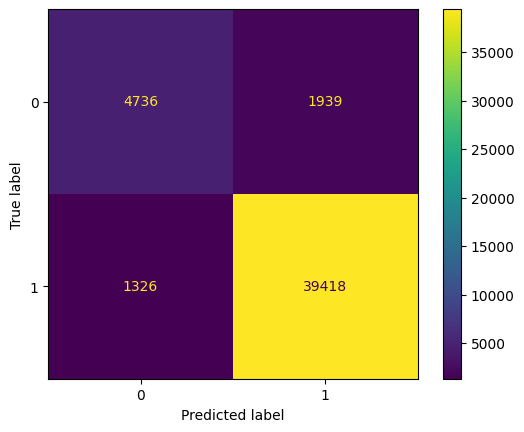


====== threshold=0.15000000000000002 ======
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.85      0.85     47419
weighted avg       0.93      0.93      0.93     47419




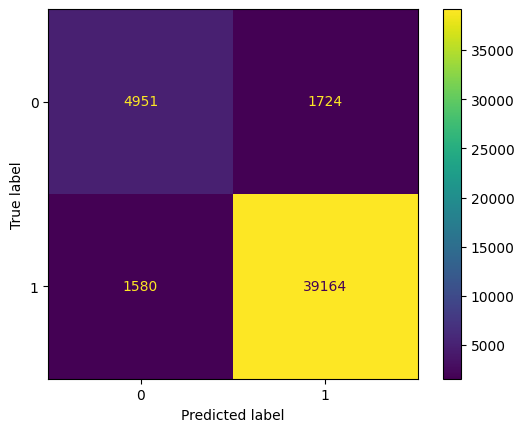


====== threshold=0.2 ======
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.86      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




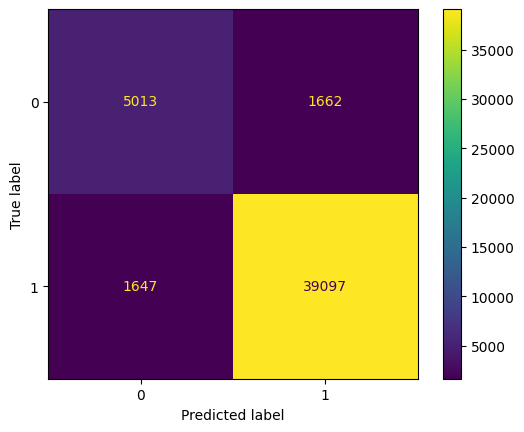


====== threshold=0.25 ======
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




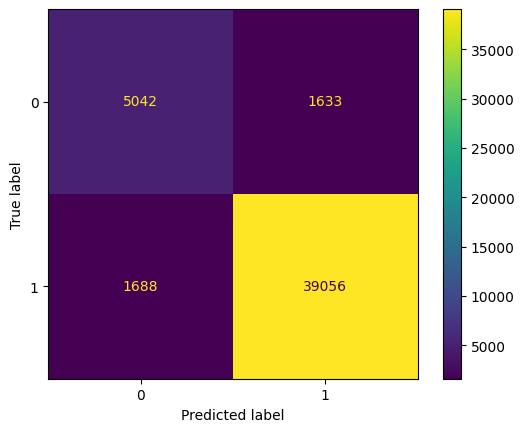


====== threshold=0.30000000000000004 ======
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      6675
           1       0.96      0.96      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.86      0.86     47419
weighted avg       0.93      0.93      0.93     47419




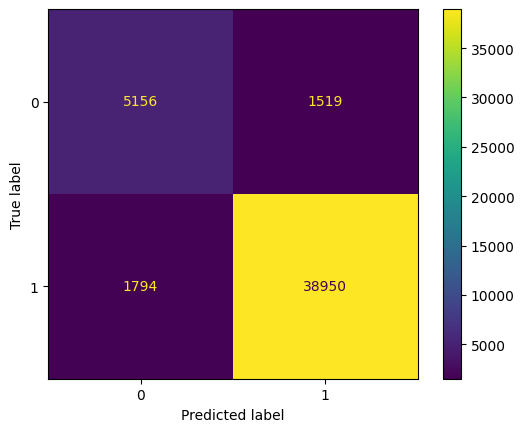


====== threshold=0.35000000000000003 ======
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




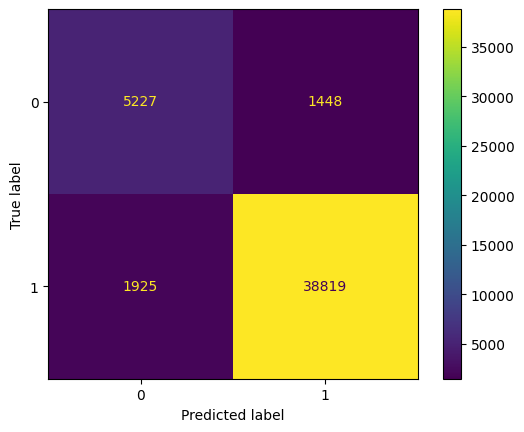


====== threshold=0.4 ======
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      6675
           1       0.96      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.85      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




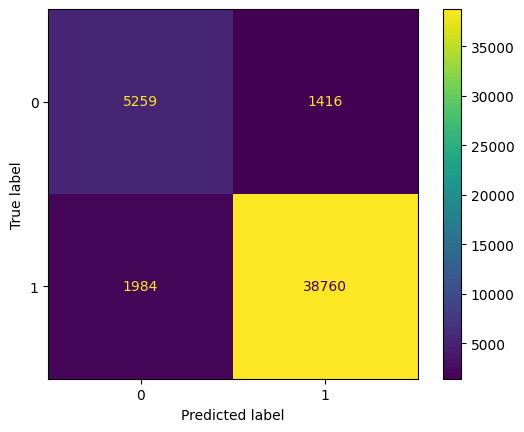


====== threshold=0.45 ======
              precision    recall  f1-score   support

           0       0.72      0.80      0.75      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




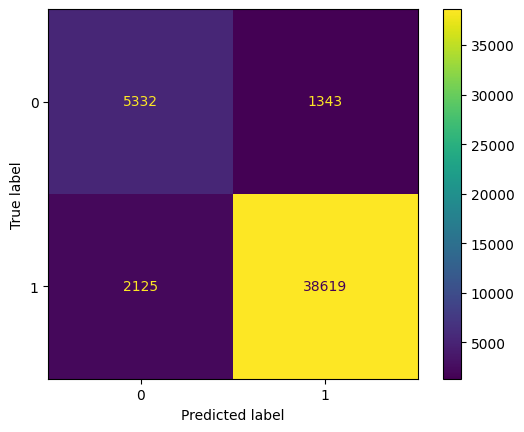


====== threshold=0.5 ======
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.87      0.86     47419
weighted avg       0.93      0.93      0.93     47419




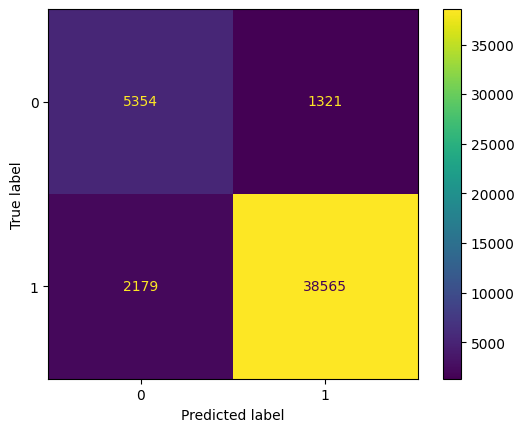


====== threshold=0.55 ======
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6675
           1       0.97      0.95      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.84      0.87      0.85     47419
weighted avg       0.93      0.93      0.93     47419




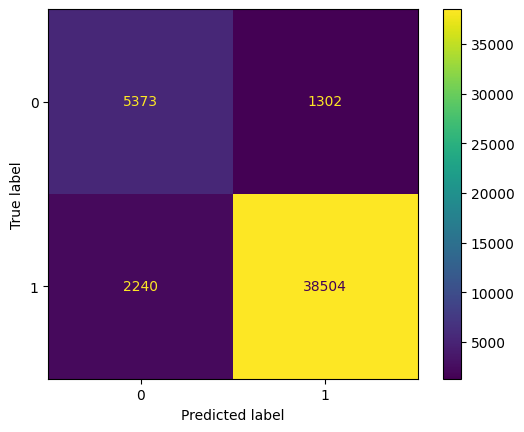


====== threshold=0.6000000000000001 ======
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6675
           1       0.97      0.94      0.96     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.88      0.85     47419
weighted avg       0.93      0.92      0.93     47419




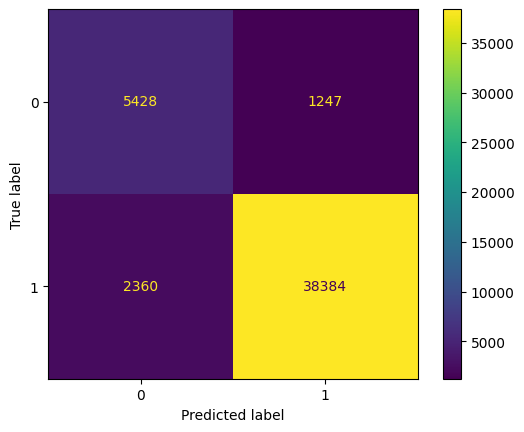


====== threshold=0.65 ======
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.88      0.85     47419
weighted avg       0.93      0.92      0.93     47419




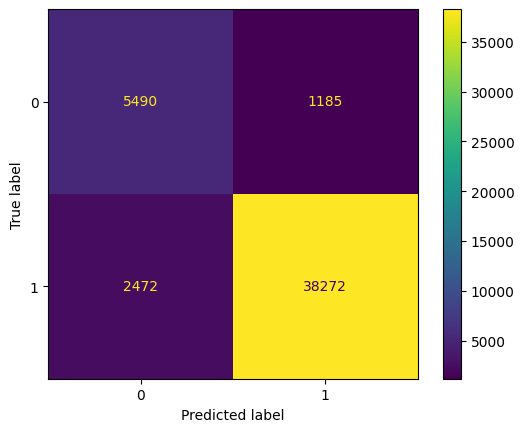


====== threshold=0.7000000000000001 ======
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      6675
           1       0.97      0.94      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.83      0.88      0.85     47419
weighted avg       0.93      0.92      0.92     47419




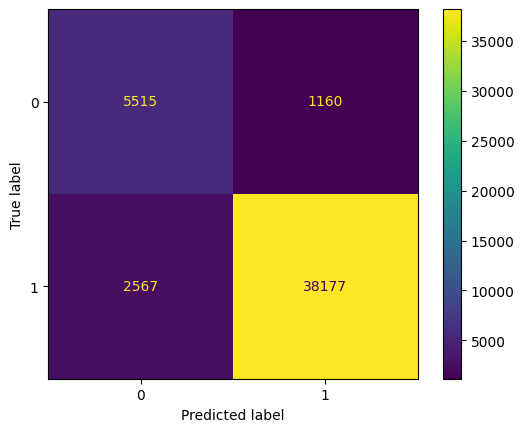


====== threshold=0.75 ======
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.88      0.85     47419
weighted avg       0.93      0.92      0.92     47419




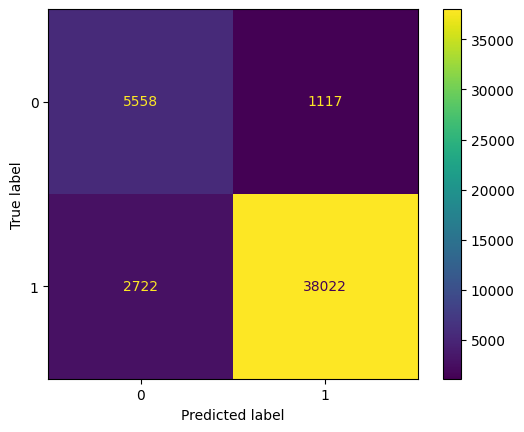


====== threshold=0.8 ======
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      6675
           1       0.97      0.93      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.82      0.88      0.85     47419
weighted avg       0.93      0.92      0.92     47419




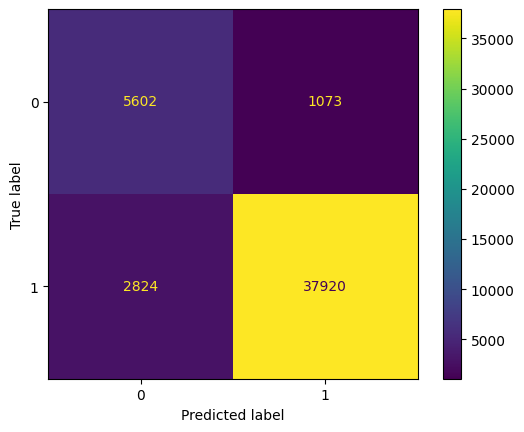


====== threshold=0.8500000000000001 ======
              precision    recall  f1-score   support

           0       0.64      0.86      0.73      6675
           1       0.98      0.92      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.81      0.89      0.84     47419
weighted avg       0.93      0.91      0.92     47419




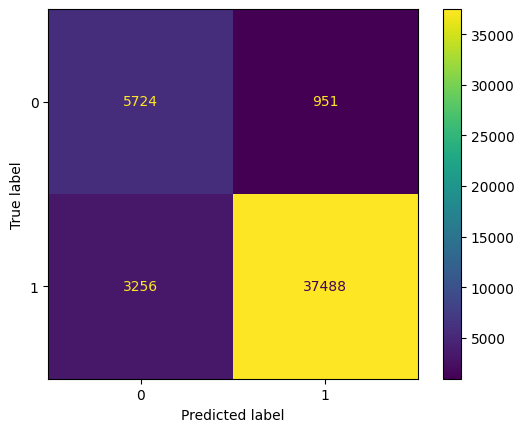


====== threshold=0.9 ======
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      6675
           1       0.98      0.91      0.94     40744

    accuracy                           0.91     47419
   macro avg       0.80      0.89      0.83     47419
weighted avg       0.93      0.91      0.91     47419




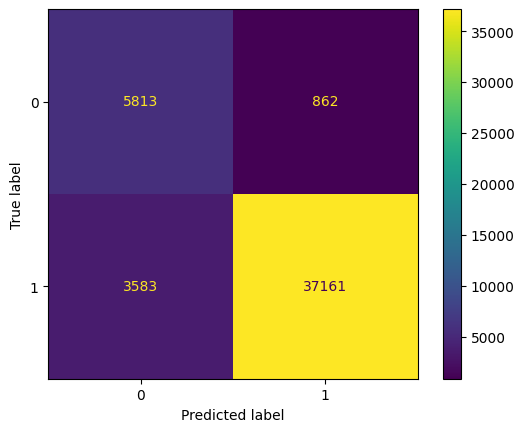


====== threshold=0.9500000000000001 ======
              precision    recall  f1-score   support

           0       0.56      0.91      0.70      6675
           1       0.98      0.89      0.93     40744

    accuracy                           0.89     47419
   macro avg       0.77      0.90      0.81     47419
weighted avg       0.92      0.89      0.90     47419




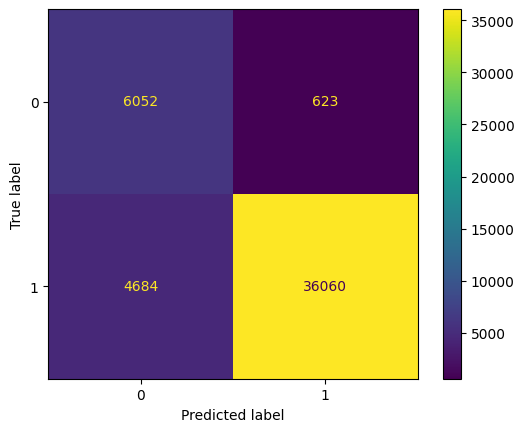

In [ ]:
threshold_selection(cb_with_probs, X_test)